# Supervised bias analysis CUB data 2019
#### Plots used for report *Addendum Bias prevented*

This notebook is used to answer the following questions about the CUB-process in 2019:

* Question 1: What was the distribution of students with a migration background in the 2019 college grant population?

* Question 2: Were students with a migration background in 2019 overrepresented in the higher risk categories that followed from the risk profile?

* Question 2a: Is there a relationship between the criteria used in the risk profile and students with a migration background?

* Question 3: Were students with a migration background in 2019 more often manually selected for a control procedure than students with a Dutch origin?

* Question 3a: To what extent does the classification of the risk profile (high or low risk) align with manual selection for a control procedure, in particular for students with a migration background compared to students of Dutch origin?

* Question 4: What was the distribution of students with a migration background in the group of students considered to have been receiving a grant unduly?

In the introduction of this notebook the data is loaded and prepared. Thereafter, the questions are sequentially answered. The notebooks concludes with a funnel visualization that gives an overview of the the CUB process as a whole in 2019.

In [1]:
import warnings
import numpy as np
import pandas as pd
from helper_functions import *
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings('ignore')

# Part 1 - Load and clean data

In [2]:
# loading data 
sheet_name = 'Table 2'
df = pd.read_excel('../DUO_CUB_Netherlands_Statistics.xlsx', sheet_name=sheet_name, skiprows=3)

In [3]:
# delete '\n' and 'number' for each columns
df.columns = [col.replace('\n', '').replace('number', '').replace('()', '').strip() for col in df.columns]

# delete last two columns
df = df[:-2]

# make category columns the index column, delete Nr column
df.set_index('Category', inplace=True)
df.drop('Nr', axis=1, inplace=True)
df.head()

,Total,Country of birth:Born in NL,Country of birth:Born outside NL,Country of origin: NL,Country of origin:Europe (excl. NL),Country of origin:Outside Europe,Born in NL x country of origin NL,Born in NL x country of origin Europe (excl. NL),Born in NL x country of origin outside Europe,Born outside NL x country of origin Europe (excl. NL),Born outside NL x country of origin outside Europe
Category,,,,,,,,,,,
Total,50230.0,38190.0,12040.0,27890.0,2770.0,19580.0,27890.0,1570.0,8730.0,1190.0,10850.0
Education: mbo 1-2,10010.0,4290.0,5720.0,2470.0,330.0,7210.0,2470.0,170.0,1660.0,160.0,5560.0
Education: mbo 3-4,26620.0,21330.0,5290.0,14810.0,1550.0,10250.0,14810.0,900.0,5620.0,660.0,4630.0
Education: hbo,12230.0,11360.0,870.0,9600.0,740.0,1900.0,9600.0,460.0,1310.0,280.0,590.0
Education: wo,1370.0,1200.0,170.0,1010.0,140.0,210.0,1010.0,50.0,140.0,90.0,80.0


In [4]:
# check missing values
df.isnull().sum()

Total                                                    0
Country of birth:Born in NL                              0
Country of birth:Born outside NL                         0
Country of origin: NL                                    0
Country of origin:Europe (excl. NL)                      0
Country of origin:Outside Europe                         0
Born in NL x country of origin NL                        0
Born in NL x country of origin Europe (excl. NL)         0
Born in NL x country of origin outside Europe            0
Born outside NL x country of origin Europe (excl. NL)    0
Born outside NL x country of origin outside Europe       0
dtype: int64

### Define new groups

In [5]:
# get number of columns except the first one, also get number of rows
n_col = len(df.columns) - 1
n_row = len(df)

# Columns - 3 categories
df['Migrants'] = df['Country of birth:Born outside NL']
df['Childs of migrant'] = df['Born in NL x country of origin Europe (excl. NL)'] + df['Born in NL x country of origin outside Europe']
df['Dutch origin'] = df['Born in NL x country of origin NL']

# Columns - 5 categories
## Migrants (1st gen)
df['Non-European migrants'] = df['Born outside NL x country of origin outside Europe']
df['European migrants'] = df['Born outside NL x country of origin Europe (excl. NL)']

## Childs of migrant(s) (2nd gen)
df['Childs non-European migrant'] = df['Born in NL x country of origin outside Europe']
df['Childs European migrant'] = df['Born in NL x country of origin Europe (excl. NL)']

## All migrants (total population without Dutch origin)
df['Migration background'] = df['Migrants'] + df['Childs of migrant']

## EU and non-EU migrants 
df['Non-European migration background'] = df['Born outside NL x country of origin outside Europe'] + df['Born in NL x country of origin outside Europe']
df['European migration background'] = df['Born outside NL x country of origin Europe (excl. NL)'] + df['Born in NL x country of origin Europe (excl. NL)']

# merge mbo 1-2 and 3-4 
df.loc['mbo', :] = df.loc['Education: mbo 1-2', :] + df.loc['Education: mbo 3-4', :]

# age mbo 1-2 and 3-4
df.loc['Age: 15-18 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 15-18 years',:] + df.loc['Education: mbo 3-4 & Age: 15-18 years',:]
df.loc['Age: 19-20 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 19-20 years',:] + df.loc['Education: mbo 3-4 & Age: 19-20 years',:]
df.loc['Age: 21-22 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 21-22 years',:] + df.loc['Education: mbo 3-4 & Age: 21-22 years',:]
df.loc['Age: 23-24 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 23-24 years',:] + df.loc['Education: mbo 3-4 & Age: 23-24 years',:]
df.loc['Age: 25-50 years (mbo)',:] = df.loc['Education: mbo 1-2 & Age: 25-50 years',:] + df.loc['Education: mbo 3-4 & Age: 25-50 years',:]

# afstand mbo 1-2 and 3-4
df.loc['Distance: 0km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 0km',:] + df.loc['Education: mbo 3-4 & Distance: 0km',:]
df.loc['Distance: 1m-1km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 1m-1km',:] + df.loc['Education: mbo 3-4 & Distance: 1m-1km',:]
df.loc['Distance: 1-2km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 1-2km',:] + df.loc['Education: mbo 3-4 & Distance: 1-2km',:]
df.loc['Distance: 2-5km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 2-5km',:] + df.loc['Education: mbo 3-4 & Distance: 2-5km',:]
df.loc['Distance: 5-10km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 5-10km',:] + df.loc['Education: mbo 3-4 & Distance: 5-10km',:]
df.loc['Distance: 10-20km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 10-20km',:] + df.loc['Education: mbo 3-4 & Distance: 10-20km',:]
df.loc['Distance: 20-50km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 20-50km',:] + df.loc['Education: mbo 3-4 & Distance: 20-50km',:]
df.loc['Distance: 50-500km (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: 50-500km',:] + df.loc['Education: mbo 3-4 & Distance: 50-500km',:]
df.loc['Distance: unknown (mbo)',:] = df.loc['Education: mbo 1-2 & Distance: unknown',:] + df.loc['Education: mbo 3-4 & Distance: unknown',:]

# New columns about CUB process

# High risk (category 1 + 2), low risk (category 3 + 4 + 5) and unknown (category 6)
df.loc['High risk', :] = df.loc['Risk category 1', :] + df.loc['Risk category 2', :]
n_high_risk_form = '{:,}'.format(int(df.loc['High risk', 'Total'])).replace(',','.')
df.loc['Low risk', :]= df.loc['Risk category 3', :] + df.loc['Risk category 4', :] + df.loc['Risk category 5', :]
n_low_risk_form = '{:,}'.format(int(df.loc['Low risk', 'Total'])).replace(',','.')
df.loc['Unknown risk', :] = df.loc['Risk category 6', :]
n_unknown_risk_form = '{:,}'.format(int(df.loc['Unknown risk', 'Total'])).replace(',','.')

# High risk (category 1 + 2) and selected for hosue visit
df.loc['High risk and selected for control', :] = df.loc['Risk category 1 & Selected for control: yes', :] + df.loc['Risk category 2 & Selected for control: yes', :]
df.loc['High risk and not selected for control', :] = df.loc['Risk category 1 & Selected for control: no', :] + df.loc['Risk category 2 & Selected for control: no', :]
df.loc['Low risk and selected for control', :] = df.loc['Risk category 3 & Selected for control: yes', :] + df.loc['Risk category 4 & Selected for control: yes', :] + df.loc['Risk category 5 & Selected for control: yes', :]
df.loc['Low risk and not selected for control', :] = df.loc['Risk category 3 & Selected for control: no', :] + df.loc['Risk category 4 & Selected for control: no', :] + df.loc['Risk category 5 & Selected for control: no', :]
df.loc['Unknown risk and selected for control', :] = df.loc['Risk category 6 & Selected for control: yes', :]
df.loc['Unknown risk and not selected for control', :] = df.loc['Risk category 6 & Selected for control: no', :]

# House visits, no house visits
df.loc['No house visit', :] = df.loc['Outcome house visit: could not take place', :] + df.loc['Outcome house visit: not selected for control', :]
df.loc['House visit', :] = df.loc['Outcome house visit: unduly'] + df.loc['Outcome house visit: duly']

# House visits, duly (directly and after appeal) and unduly
df.loc['House visit, duly (directly and after appeal)'] = df.loc['Outcome house visit: duly'] + df.loc['Unduly, appeal successful']
df.loc['House visit, unduly'] = df.loc['Outcome house visit: unduly']

### Groups of interest

In [6]:
# entire population
year = 2019
total_pop = ['Total']
total_pop_mbo = ['mbo']
n_total_pop = '{:,}'.format(int(df.loc['Total','Total'])).replace(',','.')
n_total_pop_mbo = '{:,}'.format(int(df.loc['mbo','Total'])).replace(',','.')

# migrants, childs of migrant and Dutch origin 
col_mig = ['Migrants', 'Childs of migrant', 'Dutch origin']

# migration background and Dutch origin
col_mig_binary = ['Migration background', 'Dutch origin']

# EU migrants, non-EU migrants and Dutch origin
col_mig_eu = ['Non-European migration background', 'European migration background', 'Dutch origin']

# all migrant categories
col_mig_all = ['Non-European migrants', 'European migrants', 'Childs non-European migrant', 'Childs European migrant', 'Dutch origin']

# all risk categories
risk_cat_all = ['Risk category 1', 'Risk category 2', 'Risk category 3', 'Risk category 4', 'Risk category 5', 'Risk category 6']

# education categories
cat_education = ['Education: mbo 1-2', 'Education: mbo 3-4', 'Education: hbo', 'Education: wo']
cat_education_mbo = ['Education: mbo 1-2', 'Education: mbo 3-4']

# age categories
cat_age = ['Age: 15-18 years', 'Age: 19-20 years', 'Age: 21-22 years', 'Age: 23-24 years', 'Age: 25-50 years']
cat_age_mbo = ['Age: 15-18 years (mbo)', 'Age: 19-20 years (mbo)', 'Age: 21-22 years (mbo)', 'Age: 23-24 years (mbo)', 'Age: 25-50 years (mbo)']

# distance categories
cat_distance = ['Distance: 0km', 'Distance: 1m-1km', 'Distance: 1-2km', 'Distance: 2-5km', 'Distance: 5-10km', 'Distance: 10-20km', 'Distance: 20-50km', 'Distance: 50-500km', 'Distance: unknown']
cat_distance_mbo = ['Distance: 0km (mbo)', 'Distance: 1m-1km (mbo)', 'Distance: 1-2km (mbo)', 'Distance: 2-5km (mbo)', 'Distance: 5-10km (mbo)', 'Distance: 10-20km (mbo)', 'Distance: 20-50km (mbo)', 'Distance: 50-500km (mbo)', 'Distance: unknown (mbo)']

# selected for control procedure
selected_binary = ['Selected for control: yes', 'Selected for control: no']

# high and low risk, incl. selected yes/no for control procedure
H_L_risk_selected = ['High risk', 'Selected for control: yes',  'Low risk', 'Selected for control: no']

# high risk and selected yes/no for control procedure
H_risk_selected = ['High risk and selected for control', 'High risk and not selected for control']

# low risk and selected yes/no for control procedure
L_risk_selected = ['Low risk and selected for control', 'Low risk and not selected for control']

# unknown risk and yes/no for control procedure
O_risk_selected = ['Unknown risk and selected for control', 'Unknown risk and not selected for control']

# House visit - unduly, duly and no visit
house_visit = ['Outcome house visit: unduly', 'Outcome house visit: duly', 'No house visit']
n_house_visits = '{:,}'.format(int(df.loc['House visit', 'Total'])).replace(',','.')
n_no_house_visit = df.loc['No house visit', 'Total']

# 'House visit, duly (directly and after appeal)'
house_visit_duly = ['House visit, duly (directly and after appeal)']
house_visit_unduly = ['House visit, unduly']
house_visit_right_wrong = ['House visit, duly (directly and after appeal)', 'House visit, unduly']

### Color template


In [7]:
## type 1

# migrants (brown)
c_migr = '#843C38'

# childs of migrant (light red)
c_child_migr = '#FB7F72'

# migration background - migrants and childs of migrant (red)
c_migr_and_child_migr = '#E72822'

## type 2

# EU migrants (light orange) 
c_migr_eu = '#F6C6AD'

# childs of EU migrant (light purple)
c_child_migr_eu = '#E59EDD' 

# EU migrants and childs of EU migrant (blue)
c_migr_eu_and_child_migr_eu = '#005AA8'

## type 3

# non-EU migrants (orange) 
c_migr_non_eu = '#E97132'

# childs of non-EU migrant (purple)
c_child_migr_non_eu = '#A02B93' 

# non-EU migrants and childs of non-EU migrant (turquoise)
c_migr_non_eu_and_child_migr_non_eu = '#7DC9CA'

# Dutch (grey)
c_NL = '#d3d2cc'

## color groups
c_mig = [c_migr, c_child_migr, c_NL]
c_mig_binary = [c_migr_and_child_migr, c_NL]
c_mig_eu = [c_migr_non_eu_and_child_migr_non_eu, c_migr_eu_and_child_migr_eu, c_NL]
c_mig_all = [c_migr_non_eu, c_migr_eu, c_child_migr_non_eu, c_child_migr_eu, c_NL]

# Question 1: What was the distribution of students with a migration background in the 2019 college grant population?

## 2 groups: migration background and Dutch origin

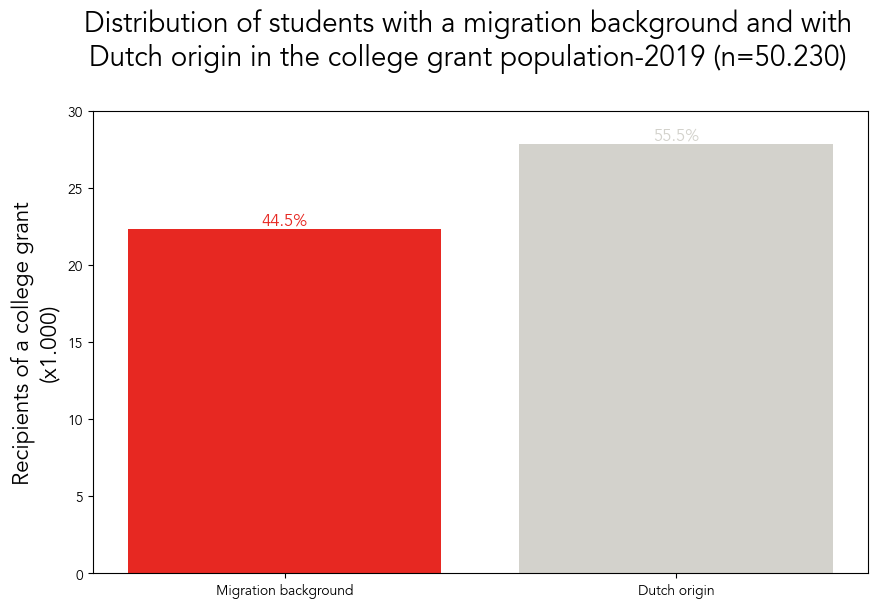

In [8]:
# data 
rows = total_pop
columns = col_mig_binary

# colors
colors = c_mig_binary

# y-ticks
ylim = 30000
n_yticks = 7

# y-axis label
yaxis_label = 'Recipients of a college grant\n(x1.000)'

# figure title
figure_title = f'Distribution of students with a migration background and with\nDutch origin in the college grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax = create_barplot(
    df, 
    rows, 
    columns, 
    colors, 
    set_xticks=True, 
    rotation_xtick_label=0,
    position_xtick_label='center',
    set_ylabel_percentage=False,
    yaxis_by_thousands=True, 
    set_ylabel=yaxis_label, 
    bar_perc_annotation=True,
    as_percentage_total=False, 
    as_percentage_category=False, 
    ylim =ylim,
    n_yticks=n_yticks,
    put_number_on_top_bar=False,
    figure_title=figure_title)

plt.show()

#### mbo-students

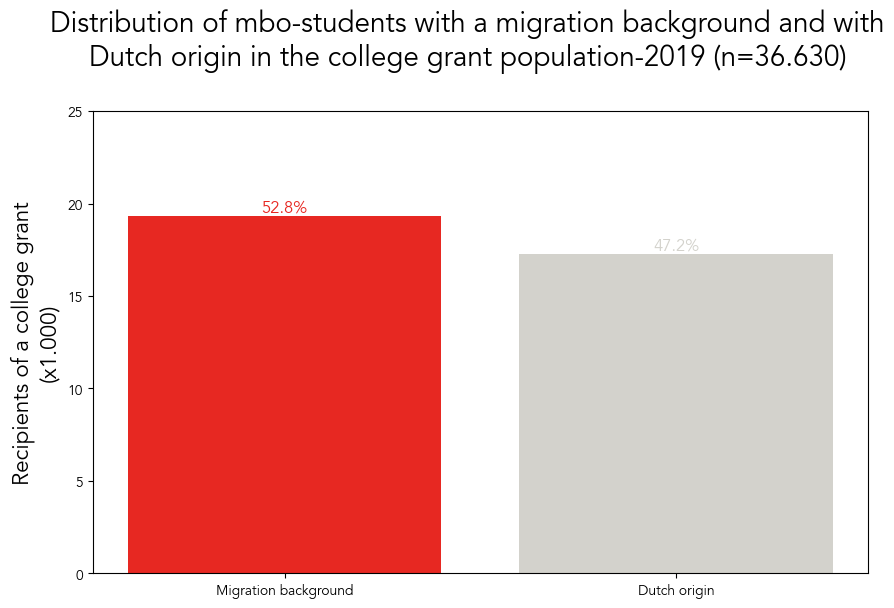

In [9]:
# data 
rows = total_pop_mbo
columns = col_mig_binary

# colors
colors = c_mig_binary

# y-ticks
ylim = 25000
n_yticks = 6

# y-axis label
yaxis_label = 'Recipients of a college grant\n(x1.000)'

# figure title
figure_title = f'Distribution of mbo-students with a migration background and with\nDutch origin in the college grant population-{year} (n={n_total_pop_mbo})'

# plot function
data, fig, ax = create_barplot(
    df, 
    rows, 
    columns, 
    colors, 
    set_xticks=True, 
    rotation_xtick_label=0,
    position_xtick_label='center',
    set_ylabel_percentage=False,
    yaxis_by_thousands=True, 
    set_ylabel=yaxis_label, 
    bar_perc_annotation=True,
    as_percentage_total=False, 
    as_percentage_category=False, 
    ylim =ylim,
    n_yticks=n_yticks,
    put_number_on_top_bar=False,
    figure_title=figure_title)

plt.show()

## 3 groups: (non-)European migration background and Dutch origin

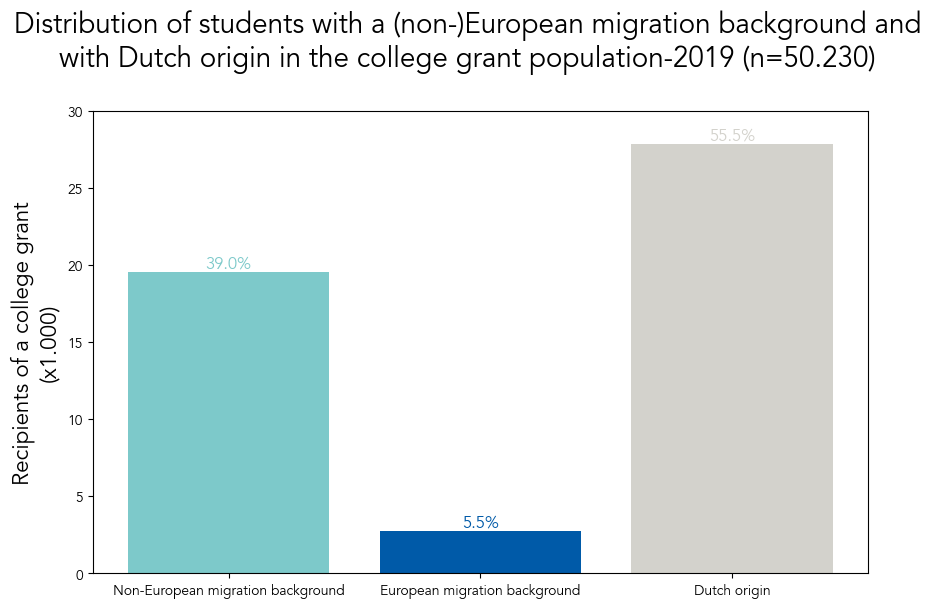

In [10]:
# data 
rows = total_pop
columns = col_mig_eu

# colors
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['Non-European migration background', 'European migration background', 'Dutch origin']

# y-ticks
ylim = 30000
n_yticks = 7

# y-axis label
yaxis_label = 'Recipients of a college grant\n(x1.000)'

# figure title
figure_title = f'Distribution of students with a (non-)European migration background and\nwith Dutch origin in the college grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax = create_barplot(df, 
                               rows, 
                               columns, 
                               colors, 
                               set_xticks=True, 
                               custom_xticks=custom_xticks,
                               rotation_xtick_label=0,
                               position_xtick_label='center',
                               set_ylabel_percentage=False,
                               yaxis_by_thousands=True, 
                               set_ylabel=yaxis_label, 
                               bar_perc_annotation=True,
                               as_percentage_total=False,
                               as_percentage_category=False, 
                               ylim =ylim,
                               n_yticks=n_yticks,
                               put_number_on_top_bar=False,
                               figure_title=figure_title)

plt.show()

#### mbo-students

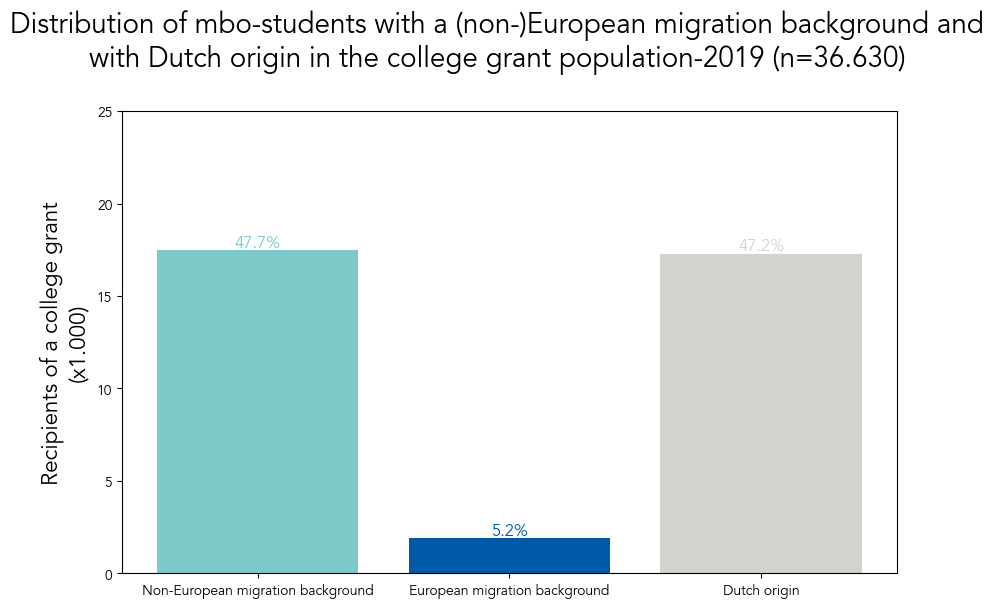

In [11]:
# data 
rows = total_pop_mbo
columns = col_mig_eu

# colors
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['Non-European migration background', 'European migration background', 'Dutch origin']

# y-ticks
ylim = 25000
n_yticks = 6

# y-axis label
yaxis_label = 'Recipients of a college grant\n(x1.000)'

# figure title
figure_title = f'Distribution of mbo-students with a (non-)European migration background and\nwith Dutch origin in the college grant population-{year} (n={n_total_pop_mbo})'

# plot function
data, fig, ax = create_barplot(df, 
                               rows, 
                               columns, 
                               colors, 
                               set_xticks=True, 
                               custom_xticks=custom_xticks,
                               rotation_xtick_label=0,
                               position_xtick_label='center',
                               set_ylabel_percentage=False,
                               yaxis_by_thousands=True, 
                               set_ylabel=yaxis_label, 
                               bar_perc_annotation=True,
                               as_percentage_total=False,
                               as_percentage_category=False, 
                               ylim =ylim,
                               n_yticks=n_yticks,
                               put_number_on_top_bar=False,
                               figure_title=figure_title)

plt.show()

## 5 groups: (non-)European migrants, childs of a (non-)European migrant and Dutch origin

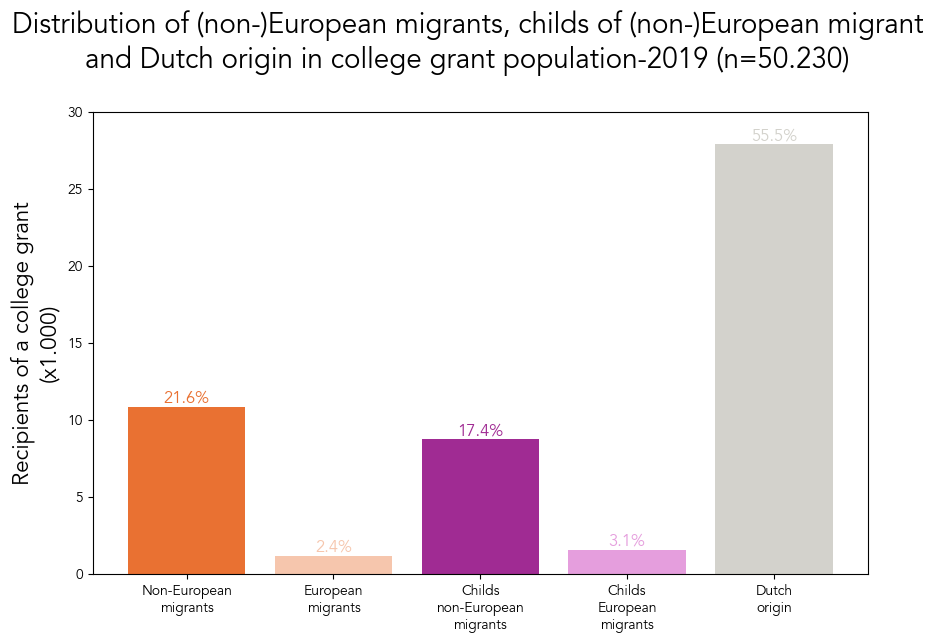

In [12]:
# data
rows = total_pop
columns = col_mig_all

# colors
colors = c_mig_all

# custom x-ticks
custom_xticks =['Non-European\nmigrants', 
                'European\nmigrants', 
                'Childs\nnon-European\nmigrants',
                'Childs\nEuropean\nmigrants',
                'Dutch\norigin']

# y-ticks
ylim = 30000
n_yticks = 7

# y-axis label
yaxis_label = 'Recipients of a college grant\n(x1.000)'

# figure title
figure_title = f'Distribution of (non-)European migrants, childs of (non-)European migrant\nand Dutch origin in college grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax = create_barplot(df, 
                               rows,
                               columns,
                               colors,
                               set_xticks=True, 
                               custom_xticks=custom_xticks,
                               rotation_xtick_label=0,
                               position_xtick_label='center',
                               set_ylabel_percentage=False,
                               set_ylabel=yaxis_label,
                               bar_perc_annotation=True,
                               yaxis_by_thousands=True, 
                               ylim =ylim,
                               n_yticks=n_yticks,
                               as_percentage_total=False, 
                               as_percentage_category=False,  
                               figure_title=figure_title)

plt.show()

#### mbo-students

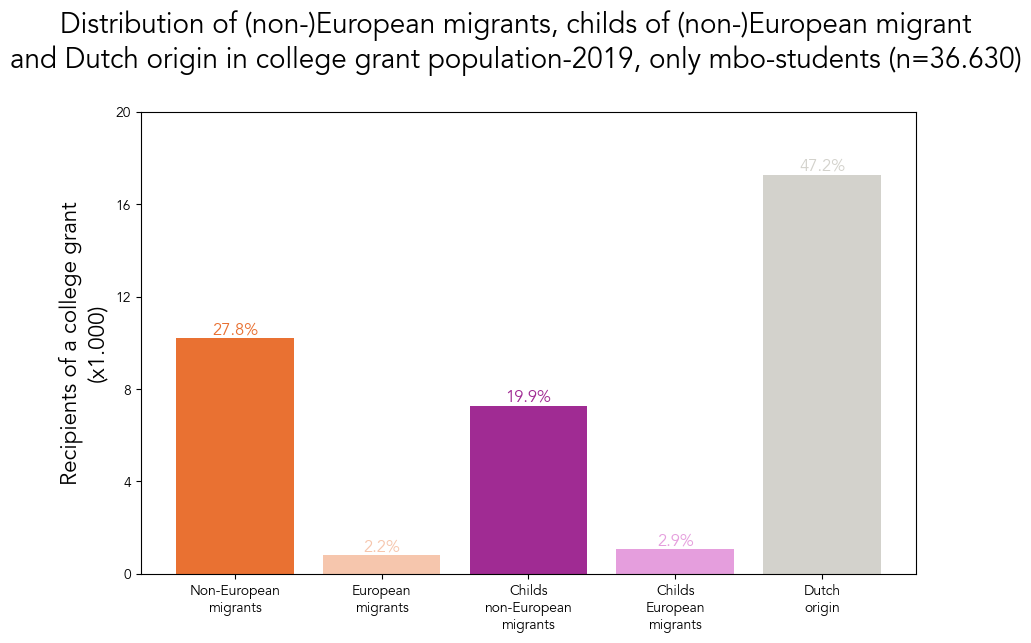

In [13]:
# data
rows = total_pop_mbo
columns = col_mig_all

# colors
colors = c_mig_all

# custom x-ticks
custom_xticks =['Non-European\nmigrants', 
                'European\nmigrants', 
                'Childs\nnon-European\nmigrants',
                'Childs\nEuropean\nmigrants',
                'Dutch\norigin']

# y-ticks
ylim = 20000
n_yticks = 6

# y-axis label
yaxis_label = 'Recipients of a college grant\n(x1.000)'

# figure title
figure_title = f'Distribution of (non-)European migrants, childs of (non-)European migrant\nand Dutch origin in college grant population-{year}, only mbo-students (n={n_total_pop_mbo})'

# plot function
data, fig, ax = create_barplot(df, 
                               rows,
                               columns,
                               colors,
                               set_xticks=True, 
                               custom_xticks=custom_xticks,
                               rotation_xtick_label=0,
                               position_xtick_label='center',
                               set_ylabel_percentage=False,
                               set_ylabel=yaxis_label,
                               bar_perc_annotation=True,
                               yaxis_by_thousands=True, 
                               ylim =ylim,
                               n_yticks=n_yticks,
                               as_percentage_total=False, 
                               as_percentage_category=False,  
                               figure_title=figure_title)

plt.show()

# Question 2: Were students with a migration background in 2019 overrepresented in the higher risk categories that followed from the risk profile?

## 2 groups: migration background and Dutch origin

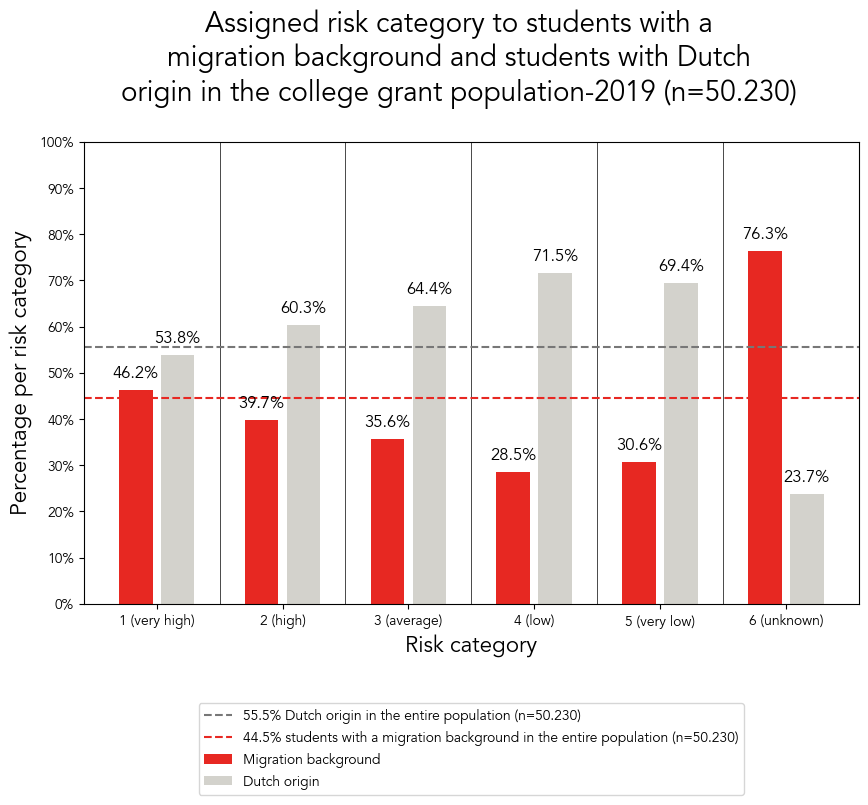

In [14]:
# data
rows = risk_cat_all
columns = col_mig_binary

# colors 
colors = c_mig_binary

# custom x-ticks
custom_xticks = ['1 (very high)', '2 (high)', '3 (average)', '4 (low)', '5 (very low)', '6 (unknown)']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per risk category'

# figure title
figure_title = f'Assigned risk category to students with a\nmigration background and students with Dutch\norigin in the college grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_category=True,
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                v_adjust_bars=0.02,
                                category_type='Risk category',
                                y_title=1.1)

# averages per group
avg_migr_binary = df.loc['Total', 'Migration background'] / df.loc['Total', 'Total']
avg_NL = df.loc['Total', 'Dutch origin'] / df.loc['Total', 'Total']

# horizontal dashed line
ax.axhline(y=avg_NL, color='#777777', label=f'{(avg_NL*100):.1f}% Dutch origin in the entire population (n={n_total_pop})', linestyle='--')
ax.axhline(y=avg_migr_binary, color=c_migr_and_child_migr, label=f'{(avg_migr_binary*100):.1f}% students with a migration background in the entire population (n={n_total_pop})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

plt.show()

## 3 groups: (non-)European migration background and Dutch origin

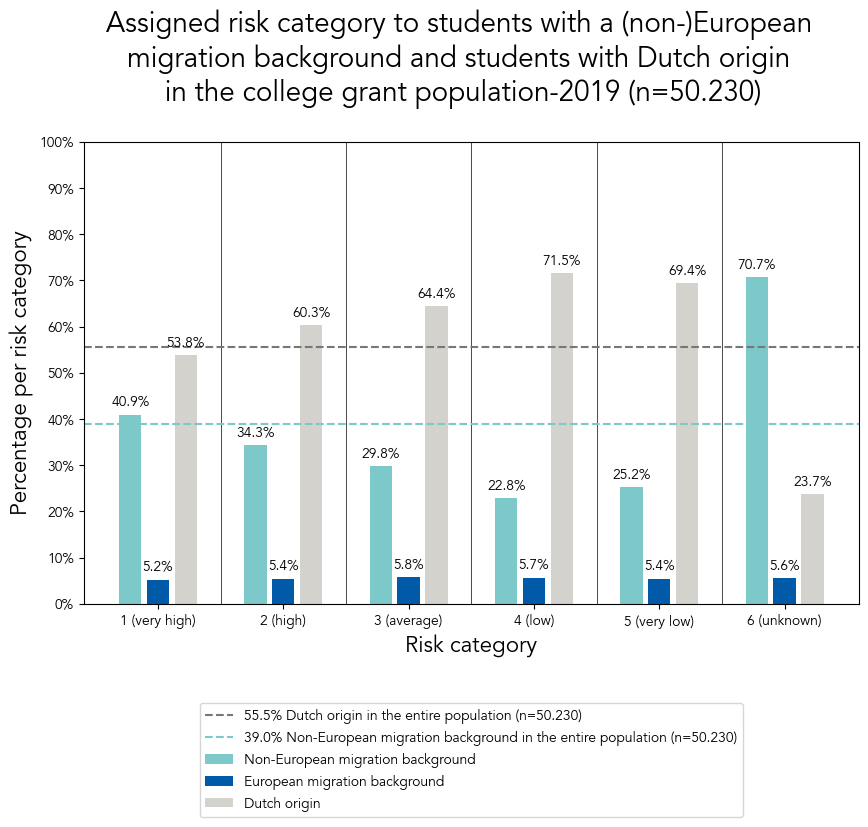

In [15]:
# data
rows = risk_cat_all
columns = col_mig_eu

# colors
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['1 (very high)', '2 (high)', '3 (average)', '4 (low)', '5 (very low)', '6 (unknown)']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per risk category'

# figure title
figure_title = f'Assigned risk category to students with a (non-)European\nmigration background and students with Dutch origin\n in the college grant population-{year} (n={n_total_pop})'

# plot function 
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                space_between_bars=0.0,
                                figure_title=figure_title,
                                category_type='Risk category', 
                                v_adjust_bars=0.01,
                                fontsize_text_bars=10,
                                y_title=1.1)

# averages per group
avg_migr_non_eu = df.loc['Total', 'Non-European migration background'] / df.loc['Total', 'Total']

# horizontal dashed line
ax.axhline(y=avg_NL, color='#777777', label=f'{(avg_NL*100):.1f}% Dutch origin in the entire population (n={n_total_pop})', linestyle='--')
ax.axhline(y=avg_migr_non_eu, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_migr_non_eu*100):.1f}% Non-European migration background in the entire population (n={n_total_pop})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

plt.show()

## 5 groups: (non-)European migrants, childs of a (non-)European migrant and Dutch origin

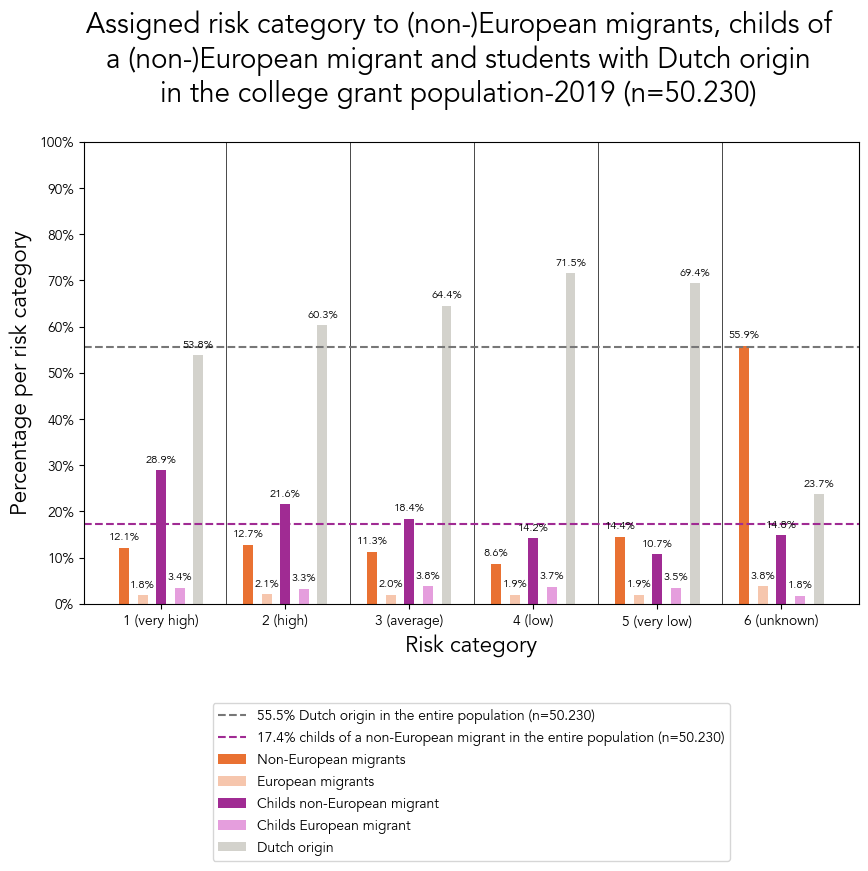

In [16]:
# data
rows = risk_cat_all
columns = col_mig_all

# colors
colors = c_mig_all

# custom x-ticks
custom_xticks = ['1 (very high)', '2 (high)', '3 (average)', '4 (low)', '5 (very low)', '6 (unknown)']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per risk category'

# figure title
figure_title = f'Assigned risk category to (non-)European migrants, childs of\na (non-)European migrant and students with Dutch origin\nin the college grant population-{year} (n={n_total_pop})'

# voeg stippellijn toe
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                space_between_bars=0.1,
                                figure_title=figure_title,
                                category_type='Risk category', 
                                v_adjust_bars=0.01,
                                fontsize_text_bars=8,
                                rotate_text_90=False,
                                y_title=1.1)

# averages per group
avg_child_migr_non_eu = df.loc['Total', 'Childs non-European migrant'] / df.loc['Total', 'Total']

# percentages from above plot
ax.axhline(y=avg_NL, color='#777777', label=f'{(avg_NL*100):.1f}% Dutch origin in the entire population (n={n_total_pop})', linestyle='--')
# ax.axhline(y=0.095, color=c_migr_non_eu, label='9.5% Non-European migrants in the entire population (n=248.650)', linestyle='--')
# ax.axhline(y=0.031, color=c_migr_eu, label='3.1% European migrants in the entire population (n=248.650)', linestyle='--')
ax.axhline(y=avg_child_migr_non_eu, color=c_child_migr_non_eu, label=f'{(avg_child_migr_non_eu*100):.1f}% childs of a non-European migrant in the entire population (n={n_total_pop})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

plt.show()

# Question 2a: Is there a relationship between the criteria used in the risk profile and students with a migration background?

### Education

#### 3 groups: (non-)European migration background and Dutch origin

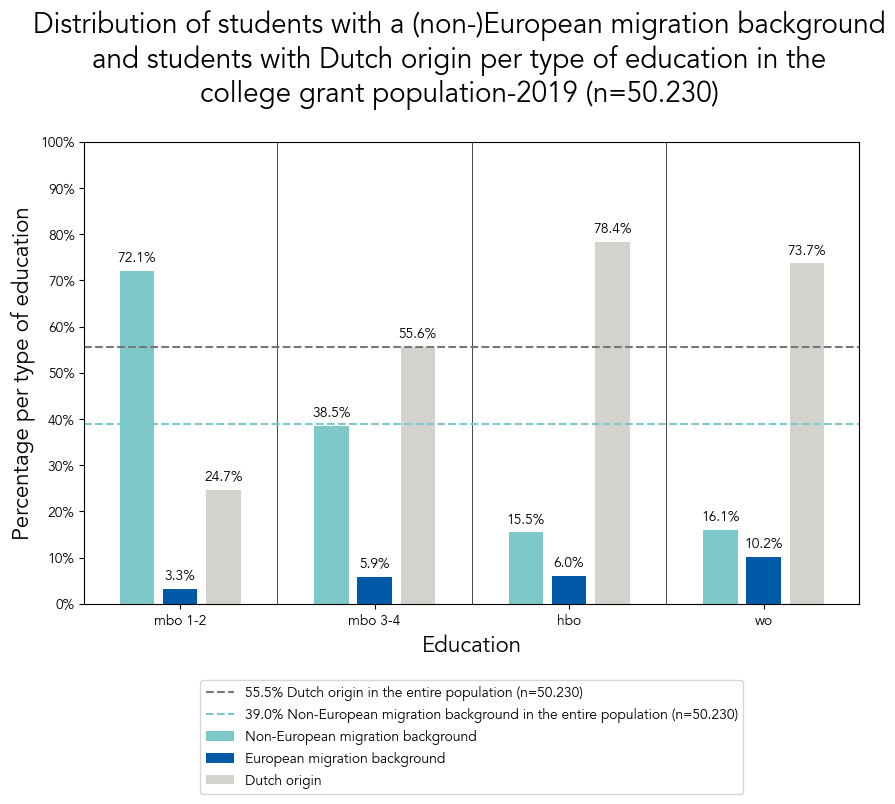

In [17]:
# data
rows = cat_education
columns = col_mig_eu

# colors 
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['mbo 1-2', 'mbo 3-4', 'hbo', 'wo']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per type of education'

# figure title
figure_title = f'Distribution of students with a (non-)European migration background\nand students with Dutch origin per type of education in the\ncollege grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns,
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                category_type='Education: ', 
                                v_adjust_bars=0.01,
                                fontsize_text_bars=10,
                                y_title=1.1)

# horizontal dashed line
ax.axhline(y=avg_NL, color='#777777', label=f'{(avg_NL*100):.1f}% Dutch origin in the entire population (n={n_total_pop})', linestyle='--')
ax.axhline(y=avg_migr_non_eu, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_migr_non_eu*100):.1f}% Non-European migration background in the entire population (n={n_total_pop})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

##### mbo

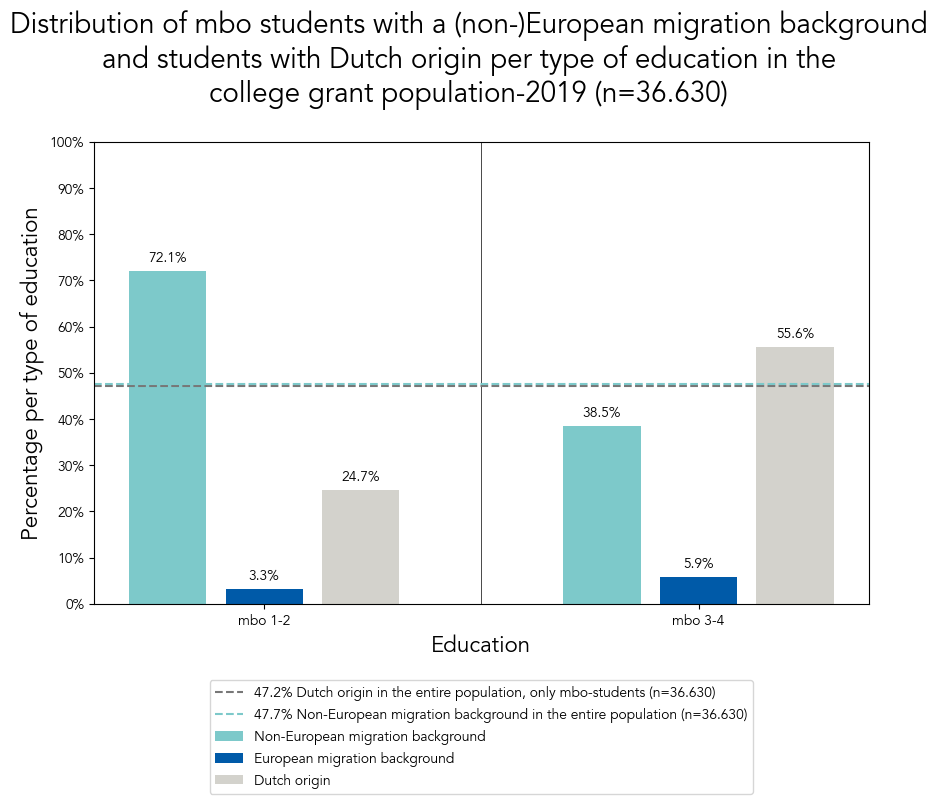

In [18]:
# data
rows = cat_education_mbo
columns = col_mig_eu

# colors 
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['mbo 1-2', 'mbo 3-4']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per type of education'

# figure title
figure_title = f'Distribution of mbo students with a (non-)European migration background\nand students with Dutch origin per type of education in the\ncollege grant population-{year} (n={n_total_pop_mbo})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns,
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                category_type='Education: ', 
                                v_adjust_bars=0.01,
                                fontsize_text_bars=10,
                                y_title=1.1)

# horizontal dashed line
avg_NL_mbo = df.loc['mbo', 'Dutch origin'] / df.loc['mbo', 'Total']
avg_migr_non_eu_mbo = df.loc['mbo', 'Non-European migration background'] / df.loc['mbo', 'Total']
ax.axhline(y=avg_NL_mbo, color='#777777', label=f'{(avg_NL_mbo*100):.1f}% Dutch origin in the entire population, only mbo-students (n={n_total_pop_mbo})', linestyle='--')
ax.axhline(y=avg_migr_non_eu_mbo, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_migr_non_eu_mbo*100):.1f}% Non-European migration background in the entire population (n={n_total_pop_mbo})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

### Age

#### 3 groups: (non-)European migration background and Dutch origin

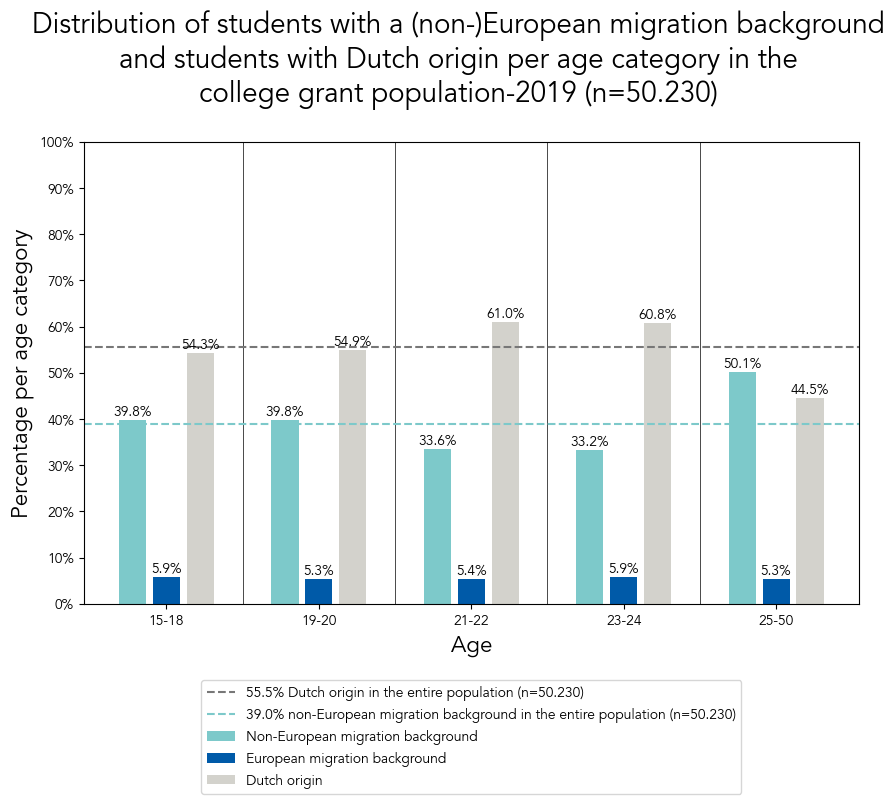

In [19]:
# data
rows = cat_age
columns = col_mig_eu

# colors 
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['15-18', '19-20', '21-22', '23-24', '25-50']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per age category'

# figure title
figure_title = f'Distribution of students with a (non-)European migration background\nand students with Dutch origin per age category in the\ncollege grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns,
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                category_type='Age: ', 
                                v_adjust_bars=0.00,
                                fontsize_text_bars=10,
                                y_title=1.1)

# horizontal dashed line
ax.axhline(y=avg_NL, color='#777777', label=f'{(avg_NL*100):.1f}% Dutch origin in the entire population (n={n_total_pop})', linestyle='--')
ax.axhline(y=avg_migr_non_eu, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_migr_non_eu*100):.1f}% non-European migration background in the entire population (n={n_total_pop})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

##### mbo students

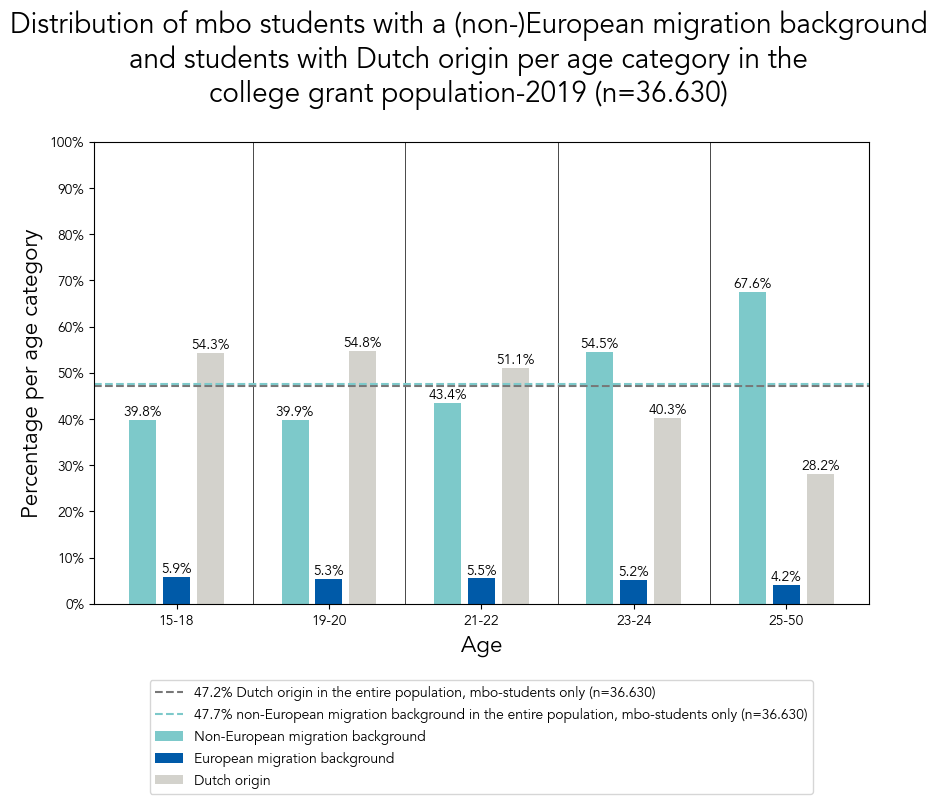

In [20]:
# data
rows = cat_age_mbo
columns = col_mig_eu

# colors 
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['15-18', '19-20', '21-22', '23-24', '25-50']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per age category'

# figure title
figure_title = f'Distribution of mbo students with a (non-)European migration background\nand students with Dutch origin per age category in the\ncollege grant population-{year} (n={n_total_pop_mbo})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns,
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                category_type='Age: ', 
                                v_adjust_bars=0.00,
                                fontsize_text_bars=10,
                                y_title=1.1)

# horizontal dashed line
ax.axhline(y=avg_NL_mbo, color='#777777', label=f'{(avg_NL_mbo*100):.1f}% Dutch origin in the entire population, mbo-students only (n={n_total_pop_mbo})', linestyle='--')
ax.axhline(y=avg_migr_non_eu_mbo, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_migr_non_eu_mbo*100):.1f}% non-European migration background in the entire population, mbo-students only (n={n_total_pop_mbo})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

### Distance

#### 3 groups: (non-)European migration background and Dutch origin

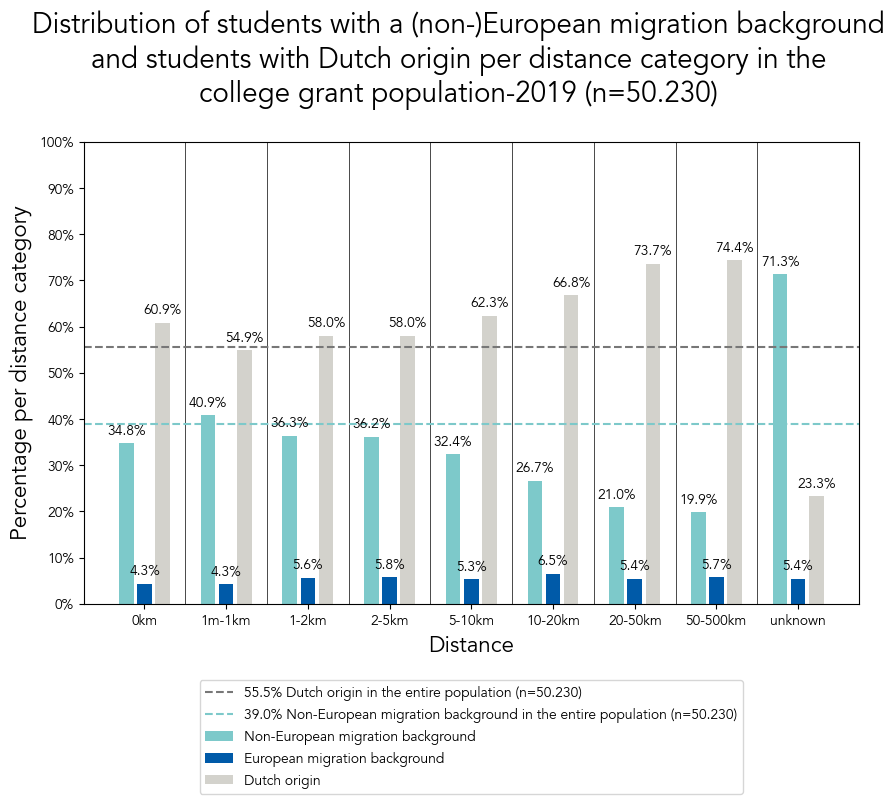

In [21]:
# data
rows = cat_distance
columns = col_mig_eu

# colors 
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per distance category'

# figure title
figure_title = f'Distribution of students with a (non-)European migration background\nand students with Dutch origin per distance category in the\ncollege grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns,
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                category_type='Distance: ', 
                                v_adjust_bars=0.01,
                                fontsize_text_bars=10,
                                y_title=1.1)

# horizontal dashed line
ax.axhline(y=avg_NL, color='#777777', label=f'{(avg_NL*100):.1f}% Dutch origin in the entire population (n={n_total_pop})', linestyle='--')
ax.axhline(y=avg_migr_non_eu, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_migr_non_eu*100):.1f}% Non-European migration background in the entire population (n={n_total_pop})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

##### mbo-students

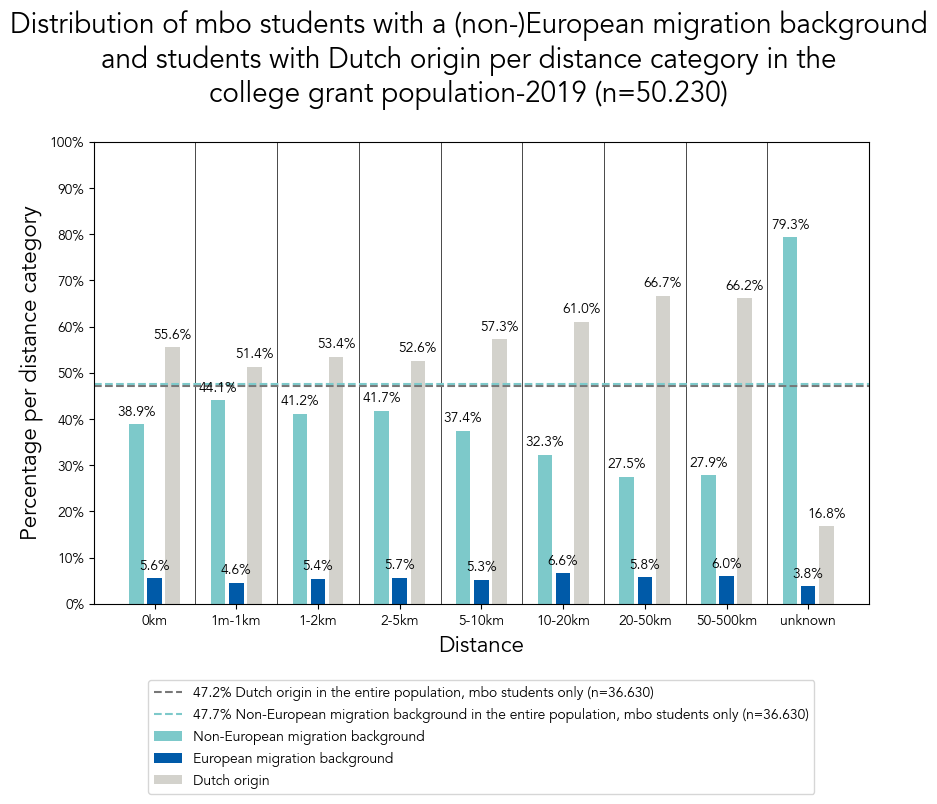

In [22]:
# data
rows = cat_distance_mbo
columns = col_mig_eu

# colors 
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['0km', '1m-1km', '1-2km', '2-5km', '5-10km', '10-20km', '20-50km', '50-500km', 'unknown']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per distance category'

# figure title
figure_title = f'Distribution of mbo students with a (non-)European migration background\nand students with Dutch origin per distance category in the\ncollege grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns,
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.5, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                category_type='Distance: ', 
                                v_adjust_bars=0.01,
                                fontsize_text_bars=10,
                                y_title=1.1)

# horizontal dashed line
ax.axhline(y=avg_NL_mbo, color='#777777', label=f'{(avg_NL_mbo*100):.1f}% Dutch origin in the entire population, mbo students only (n={n_total_pop_mbo})', linestyle='--')
ax.axhline(y=avg_migr_non_eu_mbo, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_migr_non_eu_mbo*100):.1f}% Non-European migration background in the entire population, mbo students only (n={n_total_pop_mbo})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

# Question 3: Were students with a migration background in 2019 more often manually selected for a control procedure than students with a Dutch origin?

## 2 groups: migration background and Dutch origin

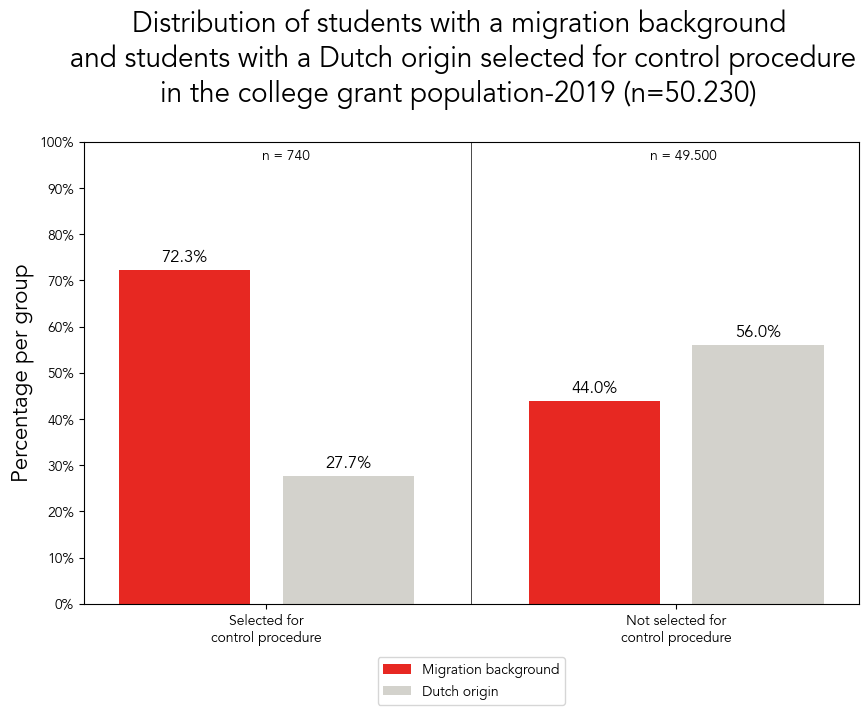

In [23]:
# data  
rows = selected_binary
columns = col_mig_binary

# colors
colors = c_mig_binary

# custom x-ticks
custom_xticks = ['Selected for\ncontrol procedure', 'Not selected for\ncontrol procedure']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per group'

# figure title
figure_title = f'Distribution of students with a migration background\n and students with a Dutch origin selected for control procedure\nin the college grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns,
                                colors, 
                                custom_xticks=custom_xticks,
                                set_xticks=True, 
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title=1.1)

# legend
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center')

# get the n of the 'Total'
n_Total = df.loc['Total', 'Total']

# get the n of the 'wel geselecteerd voor controle'
n_house_visit = df.loc['House visit', 'Total']
perc_housevisit = n_house_visit / n_Total

# get the n of the 'niet geselecteerd voor controle'
perc_no_housevisit = n_no_house_visit / n_Total

# plot coordinates
step_per_n = 0.5
start_x_n= 0.23
start_y_n = 0.96

# text annotation
x_i = start_x_n
for n in [n_house_visit, n_no_house_visit]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

plt.show()

## 3 groups: (non-)European migration background and Dutch origin

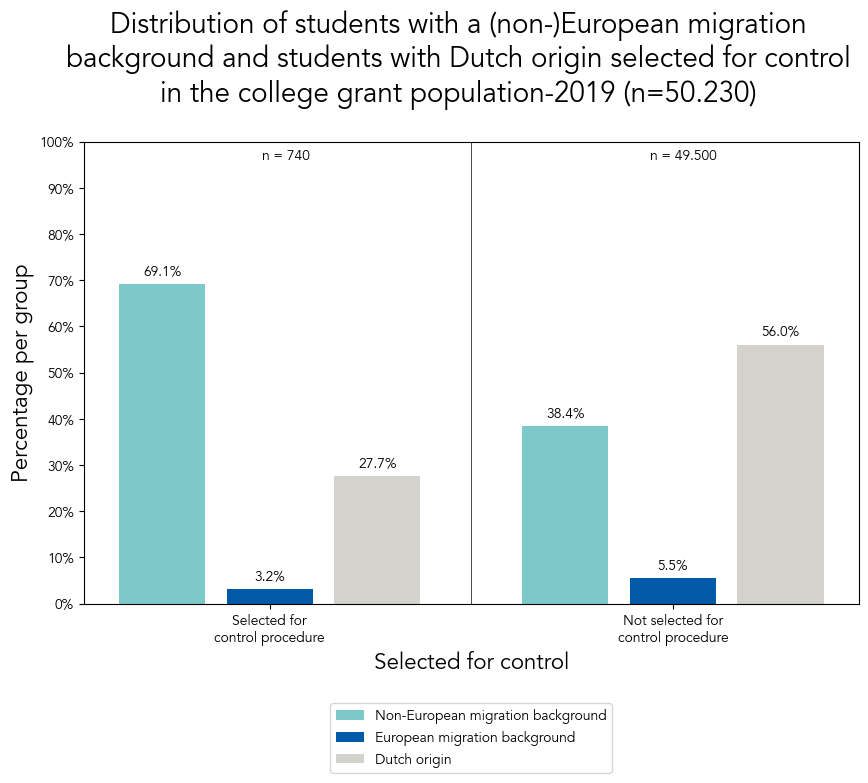

In [24]:
# data
rows = selected_binary
columns = col_mig_eu

# colors
colors = c_mig_eu

# custom x-ticks
custom_xticks = ['Selected for\ncontrol procedure', 'Not selected for\ncontrol procedure']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per group'

# figure title
figure_title = f'Distribution of students with a (non-)European migration\nbackground and students with Dutch origin selected for control\nin the college grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                space_between_bars=0.0,
                                figure_title=figure_title,
                                category_type='Selected for control: ',
                                v_adjust_bars=0.01,
                                fontsize_text_bars=10,
                                hadjust_vline=0.125,
                                y_title=1.1)

# legend
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center')

# plot coordinates
step_per_n = 0.5
start_x_n= 0.23
start_y_n = 0.96

x_i = start_x_n
for n in [n_house_visit, n_no_house_visit]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

plt.show()

# Question 3a: To what extent does the classification of the risk profile (high or low risk) align with manual selection for a control procedure, in particular for students with a migration background compared to students of Dutch origin?

## 2 groups: migration background and Dutch origin

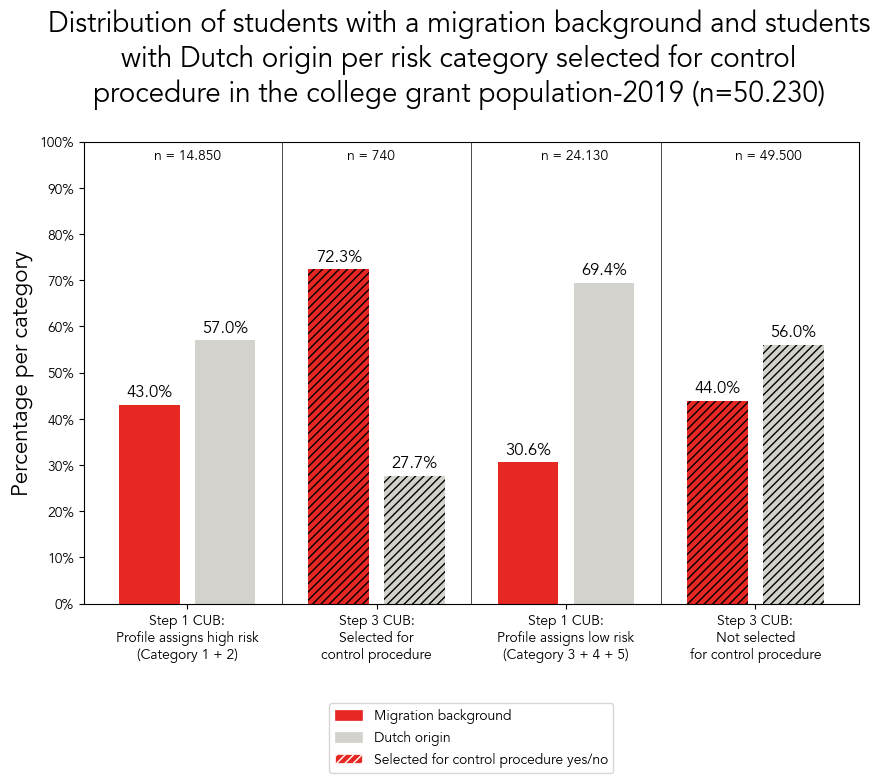

In [25]:
# data
rows = H_L_risk_selected
columns = col_mig_binary

# colors
colors = c_mig_binary

# custom xticks
custom_xticks = ['Step 1 CUB:\nProfile assigns high risk\n(Category 1 + 2)', 
                 'Step 3 CUB:\nSelected for\ncontrol procedure', 
                 'Step 1 CUB:\nProfile assigns low risk\n(Category 3 + 4 + 5)', 
                 'Step 3 CUB:\nNot selected\nfor control procedure']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per category'

# figure title
figure_title = f'Distribution of students with a migration background and students\nwith Dutch origin per risk category selected for control\nprocedure in the college grant population-{year} (n={n_total_pop})'

# fill patterns - first one remains same, second one is hatched
fill_patterns = [None, '////']

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns,
                                colors, 
                                custom_xticks=custom_xticks,
                                set_xticks=True, 
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title=1.1,
                                fill_patterns=fill_patterns)

# get the n of the 'Total'
n_Total = df.loc['Total', 'Total']

# get the n of the 'high risk'
n_high_risk = df.loc['High risk', 'Total']
perc_high_risk = n_high_risk / n_Total

# get the n of the 'low risk'
n_low_risk = df.loc['Low risk', 'Total']
perc_low_risk = n_low_risk / n_Total

# plot coordinates
step_per_n = 0.25
start_x_n= 0.09
start_y_n = 0.96

# annotate total population size
x_i = start_x_n
for n in [n_high_risk, n_house_visit, n_low_risk, n_no_house_visit]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# Create a legend with two things - one for the color and one for the hatches
legend_elements = [plt.Rectangle((0,0),1,1,  edgecolor = 'white', linewidth = 0.5, label='Migration background', color=c_migr_and_child_migr),
                   plt.Rectangle((0,0),1,1,  edgecolor = 'white', linewidth = 0.5, label='Dutch origin', color=c_NL),
                   plt.Rectangle((0,0),1,1, fc=c_migr_and_child_migr, hatch='////', edgecolor = 'white', linewidth = 0.5, label='Selected for control procedure yes/no')]

# legend
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2))

plt.show()

## 3 groups: (non-)European migration background and Dutch origin

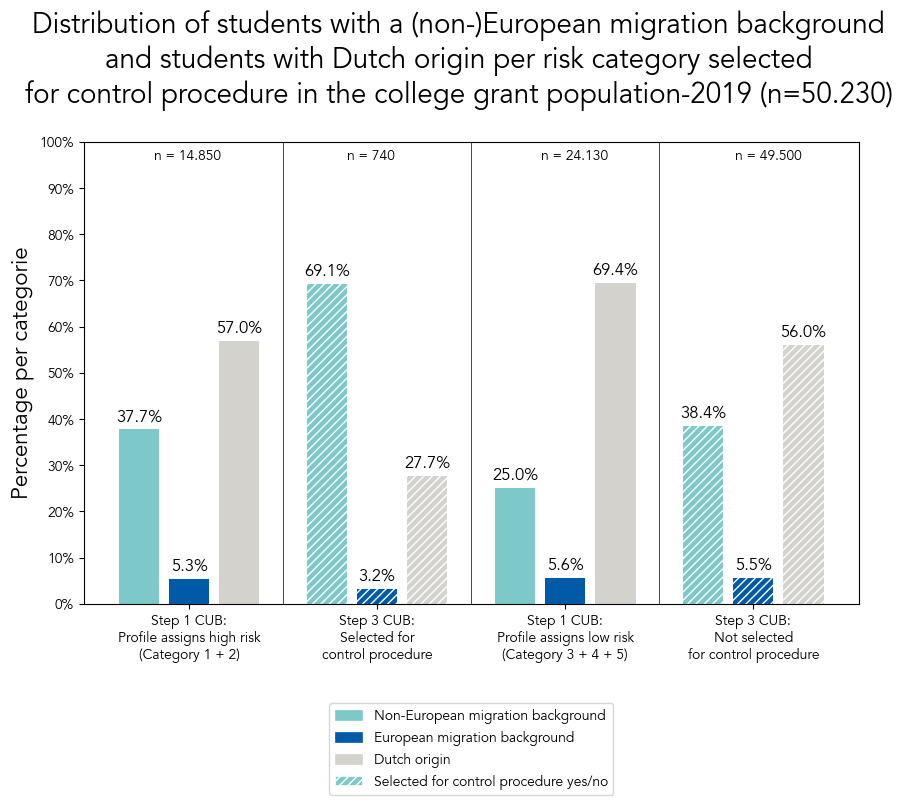

In [26]:
# data
rows = H_L_risk_selected
columns = col_mig_eu

# colors
colors = c_mig_eu

# custom xticks
custom_xticks = ['Step 1 CUB:\nProfile assigns high risk\n(Category 1 + 2)', 
                 'Step 3 CUB:\nSelected for\ncontrol procedure', 
                 'Step 1 CUB:\nProfile assigns low risk\n(Category 3 + 4 + 5)', 
                 'Step 3 CUB:\nNot selected\nfor control procedure']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per categorie'

# figure title
figure_title = f'Distribution of students with a (non-)European migration background\nand students with Dutch origin per risk category selected\nfor control procedure in the college grant population-{year} (n={n_total_pop})'

# fill patterns - first one remains same, second one is hatched
fill_patterns = [None, '////']

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                col_mig_eu, 
                                colors, 
                                custom_xticks=custom_xticks,
                                set_xticks=True, 
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title=1.1,
                                fill_patterns=fill_patterns)

# annotate total population size
x_i = start_x_n
for n in [n_high_risk, n_house_visit, n_low_risk, n_no_house_visit]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# Create a legend with two things - one for the color and one for the hatches
legend_elements = [plt.Rectangle((0,0),1,1,  edgecolor = 'black', linewidth = 0.5, label='Non-European migration background', color=c_migr_non_eu_and_child_migr_non_eu),
                    plt.Rectangle((0,0),1,1,  edgecolor = 'black', linewidth = 0.5, label='European migration background', color=c_migr_eu_and_child_migr_eu),
                    plt.Rectangle((0,0),1,1,  edgecolor = 'black', linewidth = 0.5, label='Dutch origin', color=c_NL),
                    plt.Rectangle((0,0),1,1, fc=c_migr_non_eu_and_child_migr_non_eu, hatch='////', edgecolor = 'white', linewidth = 0.5, label='Selected for control procedure yes/no')]

# legend
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.2))

plt.show()

## 2 groups: migration background and Dutch origin

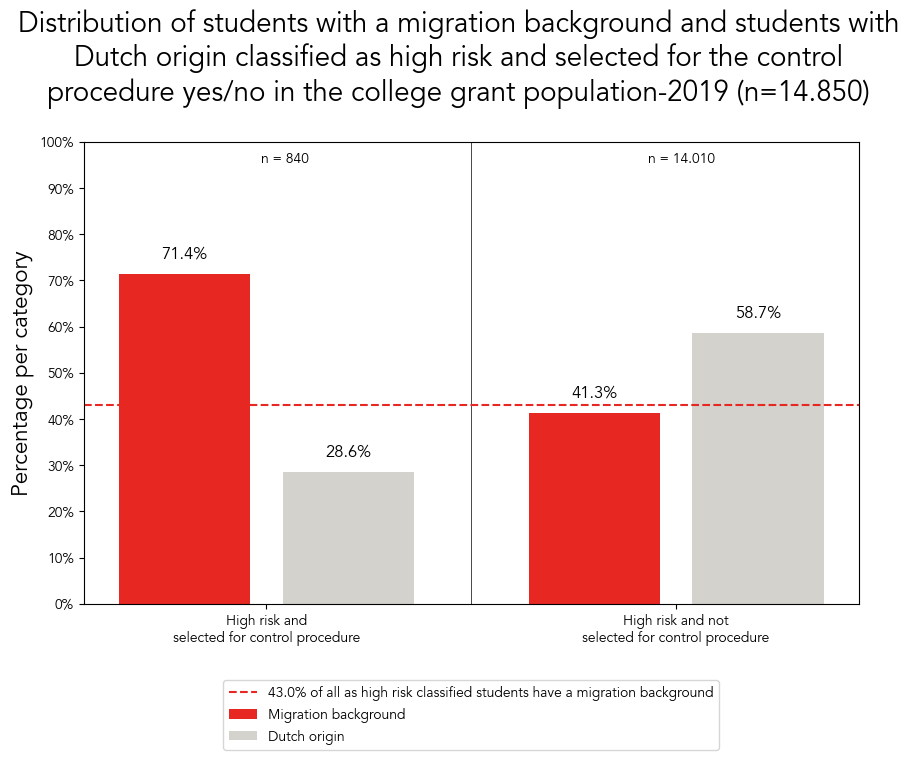

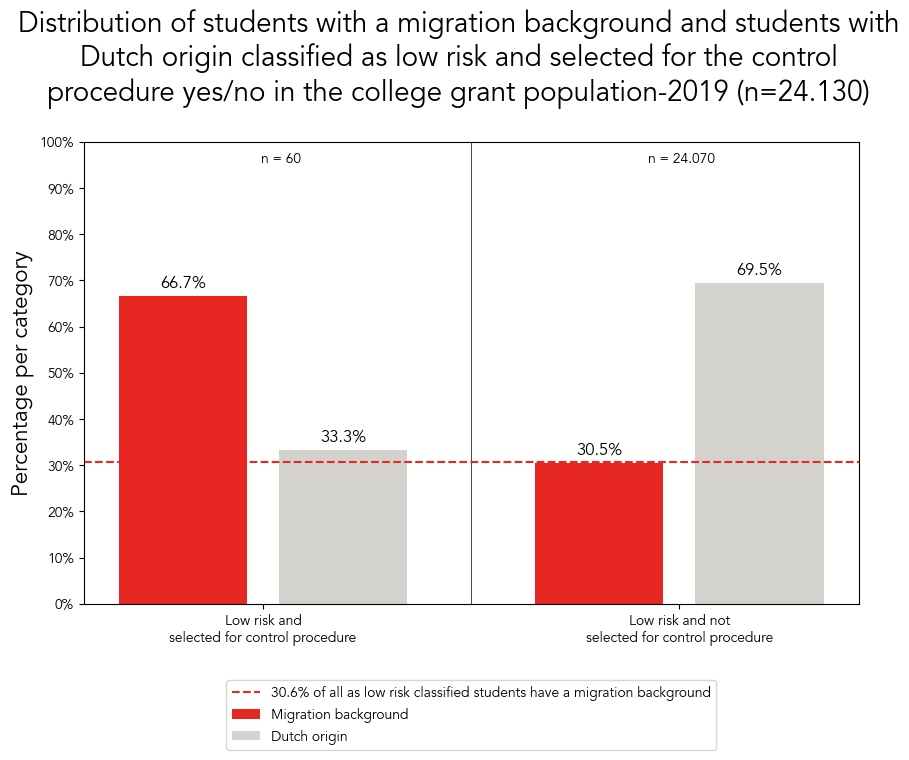

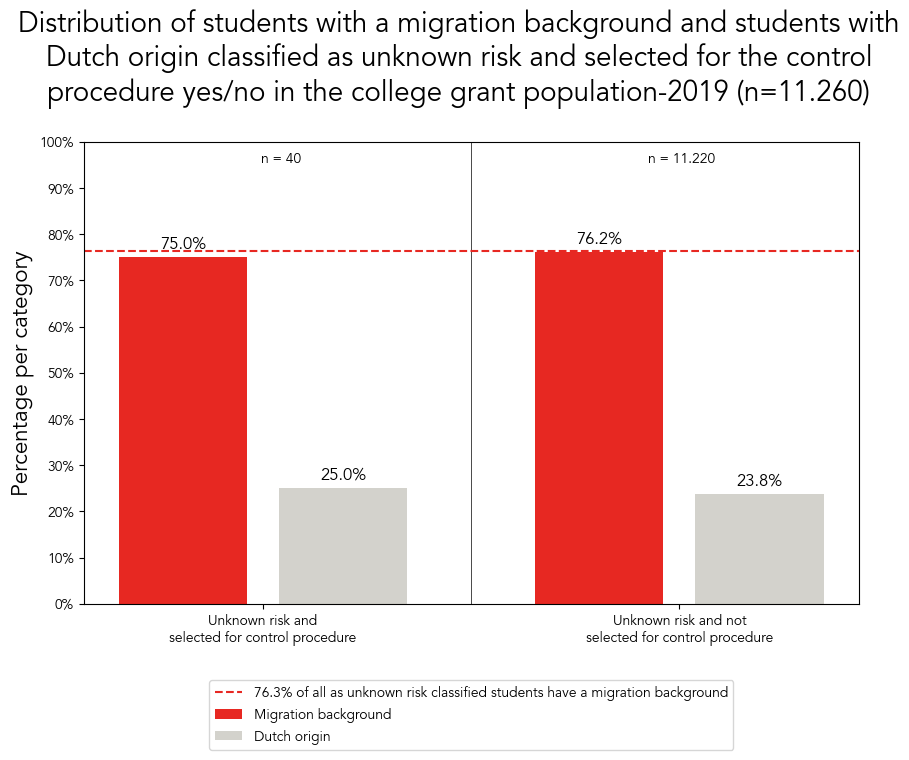

In [27]:
# data plot1
rows1 = H_risk_selected
columns = col_mig_binary

# data plot2
rows2 = L_risk_selected
columns = col_mig_binary

# data plot3
rows3 = O_risk_selected
columns = col_mig_binary

# colors
colors = c_mig_binary

# custom xticks
custom_xticks1 = ['High risk and\nselected for control procedure', 'High risk and not\nselected for control procedure']
custom_xticks2 = ['Low risk and\nselected for control procedure', 'Low risk and not\nselected for control procedure']
custom_xticks3 = ['Unknown risk and\nselected for control procedure', 'Unknown risk and not\nselected for control procedure']

# y-axis label
yaxis_label = 'Percentage per category'

# y-ticks
ylim = 1
n_yticks = 11

# figure title
figure_title1 = f'Distribution of students with a migration background and students with\nDutch origin classified as high risk and selected for the control\nprocedure yes/no in the college grant population-{year} (n={n_high_risk_form})'
figure_title2 = f'Distribution of students with a migration background and students with\nDutch origin classified as low risk and selected for the control\nprocedure yes/no in the college grant population-{year} (n={n_low_risk_form})'
figure_title3 = f'Distribution of students with a migration background and students with\nDutch origin classified as unknown risk and selected for the control\nprocedure yes/no in the college grant population-{year} (n={n_unknown_risk_form})'

# plot1 function
data, fig, ax1  = create_barplot(df, 
                                rows1, 
                                columns,
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks1,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                figure_title=figure_title1,
                                y_title=1.1,
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                v_adjust_bars=0.025,
                                vline_between_cat=True)

# plot2 function
data, fig, ax2  = create_barplot(df,
                                rows2,
                                columns,
                                colors,
                                set_xticks=True,
                                custom_xticks=custom_xticks2,  
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True,
                                as_percentage_total=False,
                                as_percentage_category=True,
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                figure_title=figure_title2,
                                put_number_on_top_bar=True,
                                space_between_cat=0.3,
                                v_adjust_bars=0.01,
                                y_title=1.1,
                                vline_between_cat=True)

# plot3 function
data, fig, ax3  = create_barplot(df,
                                rows3,
                                columns,
                                colors,
                                set_xticks=True,
                                custom_xticks=custom_xticks3,  
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True,
                                as_percentage_total=False,
                                as_percentage_category=True,
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                figure_title=figure_title3,
                                put_number_on_top_bar=True,
                                space_between_cat=0.3,
                                v_adjust_bars=0.01,
                                y_title=1.1,
                                vline_between_cat=True)

# make a vline with the average for all that have high/medium/low risk
n_high_risk_and_house_visit = df.loc['High risk and selected for control', 'Total']
n_high_risk_and_no_house_visit = df.loc['High risk and not selected for control', 'Total']
n_low_risk_and_house_visit = df.loc['Low risk and selected for control', 'Total']
n_low_risk_and_no_house_visit = df.loc['Low risk and not selected for control', 'Total']
n_unknown_risk_and_house_visit = df.loc['Unknown risk and selected for control', 'Total']
n_unknown_risk_and_no_house_visit = df.loc['Unknown risk and not selected for control', 'Total']

# plot coordinates
step_per_n = 0.5
start_x_n= 0.175
start_y_n = 1.15

# annotation of sample size plot1
x_i = start_x_n
for n in [n_high_risk_and_house_visit, n_high_risk_and_no_house_visit]:
        ax1.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# annotation of sample size plot2
x_i = start_x_n
for n in [n_low_risk_and_house_visit, n_low_risk_and_no_house_visit]:
        ax2.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# annotation of sample size plot3
x_i = start_x_n
for n in [n_unknown_risk_and_house_visit, n_unknown_risk_and_no_house_visit]:
        ax3.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# make a vline with the average for all that have high/low/unknown risk
avg_H = df.loc['High risk', 'Migration background'] / df.loc['High risk', 'Total']
avg_L = df.loc['Low risk', 'Migration background'] / df.loc['Low risk', 'Total']
avg_O = df.loc['Unknown risk', 'Migration background'] / df.loc['Unknown risk', 'Total']

# add a horizontal lines to plot 1-3
ax1.axhline(y=avg_H, color=c_migr_and_child_migr, label=f'{(avg_H*100):.1f}% of all as high risk classified students have a migration background', linestyle='--')
ax2.axhline(y=avg_L, color=c_migr_and_child_migr, label=f'{(avg_L*100):.1f}% of all as low risk classified students have a migration background', linestyle='--')
ax3.axhline(y=avg_O, color=c_migr_and_child_migr, label=f'{(avg_O*100):.1f}% of all as unknown risk classified students have a migration background', linestyle='--')

# legends for plot 1-3
ax1.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')
ax2.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')
ax3.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

## 3 groups: (non-)European migration background and Dutch origin

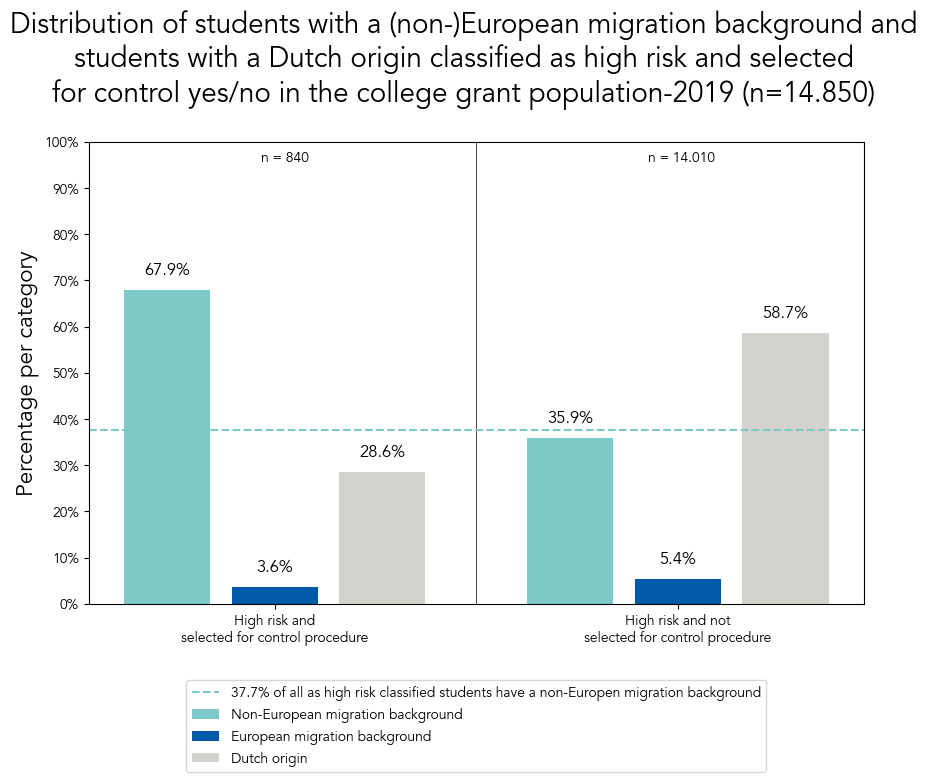

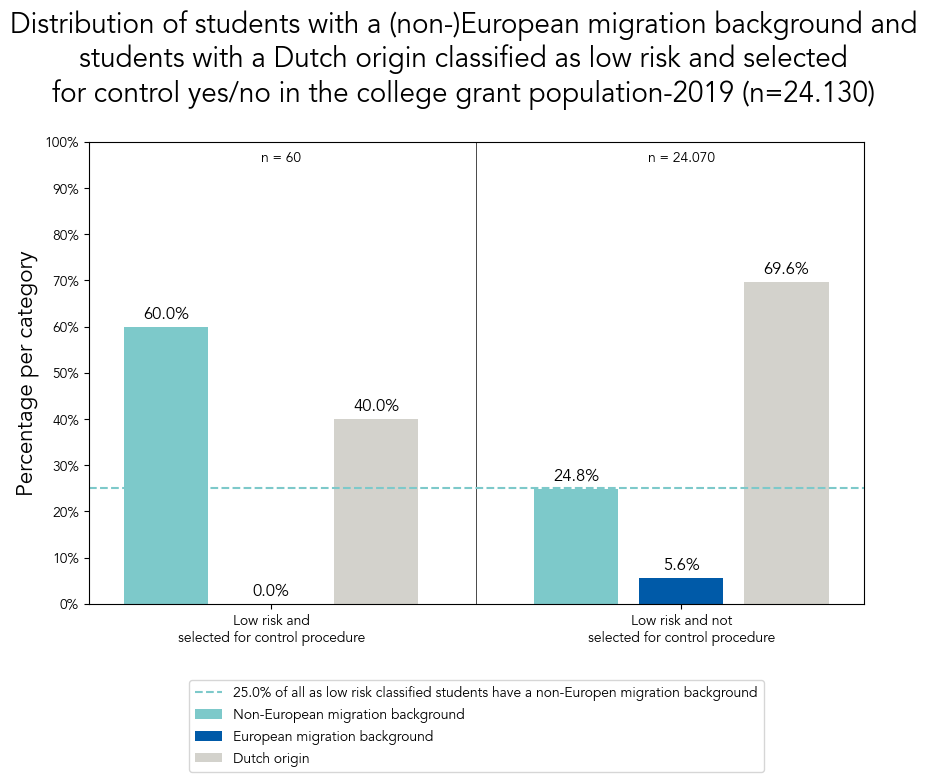

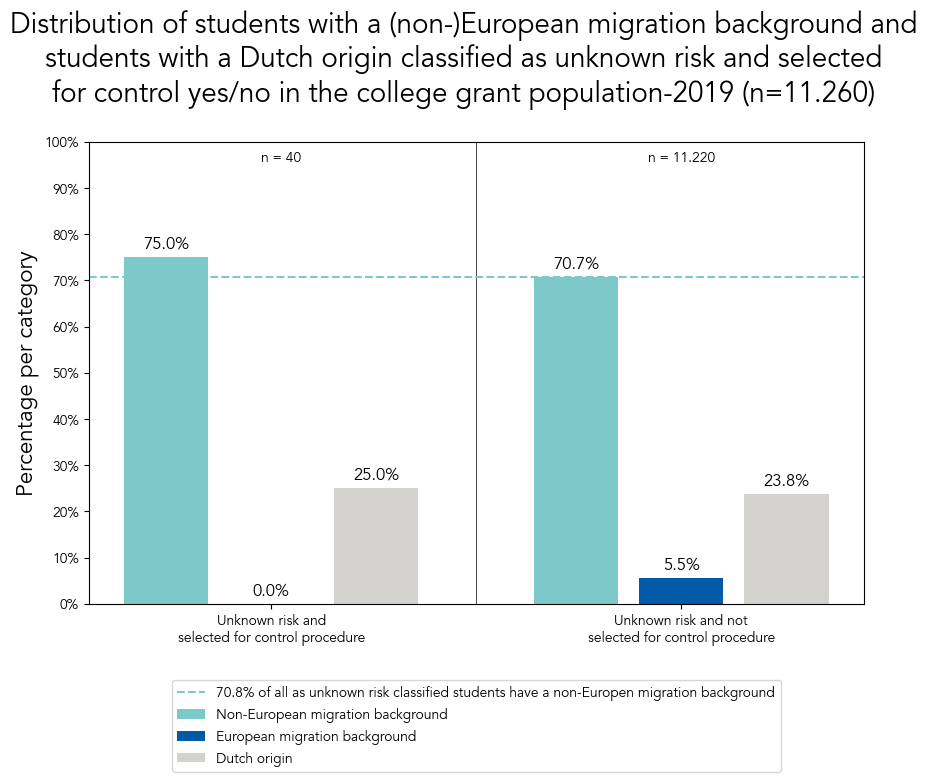

In [28]:
# data plot1
rows1 = H_risk_selected
columns = col_mig_eu

# data plot2
rows2 = L_risk_selected
columns = col_mig_eu

# data plot3
rows3 = O_risk_selected
columns = col_mig_eu

# colors
colors = c_mig_eu

# custom xticks
custom_xticks1 = ['High risk and\nselected for control procedure', 'High risk and not\nselected for control procedure']
custom_xticks2 = ['Low risk and\nselected for control procedure', 'Low risk and not\nselected for control procedure']
custom_xticks3 = ['Unknown risk and\nselected for control procedure', 'Unknown risk and not\nselected for control procedure']

# y-axis label
yaxis_label = 'Percentage per category'

# y-ticks
ylim = 1
n_yticks = 11

# figure title
figure_title1 = f'Distribution of students with a (non-)European migration background and\nstudents with a Dutch origin classified as high risk and selected\nfor control yes/no in the college grant population-{year} (n={n_high_risk_form})'
figure_title2 = f'Distribution of students with a (non-)European migration background and\nstudents with a Dutch origin classified as low risk and selected\nfor control yes/no in the college grant population-{year} (n={n_low_risk_form})'
figure_title3 = f'Distribution of students with a (non-)European migration background and\nstudents with a Dutch origin classified as unknown risk and selected\nfor control yes/no in the college grant population-{year} (n={n_unknown_risk_form})'

# plot1 function
data, fig, ax1  = create_barplot(df, 
                                rows1, 
                                columns,
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks1,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                figure_title=figure_title1,
                                y_title=1.1,
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                v_adjust_bars=0.025,
                                vline_between_cat=True)

# plot2 function
data, fig, ax2  = create_barplot(df,
                                rows2,
                                columns,
                                colors,
                                set_xticks=True,
                                custom_xticks=custom_xticks2,  
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True,
                                as_percentage_total=False,
                                as_percentage_category=True,
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                figure_title=figure_title2,
                                put_number_on_top_bar=True,
                                space_between_cat=0.3,
                                v_adjust_bars=0.01,
                                y_title=1.1,
                                vline_between_cat=True)

# plot3 function
data, fig, ax3  = create_barplot(df,
                                rows3,
                                columns,
                                colors,
                                set_xticks=True,
                                custom_xticks=custom_xticks3,  
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True,
                                as_percentage_total=False,
                                as_percentage_category=True,
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                figure_title=figure_title3,
                                put_number_on_top_bar=True,
                                space_between_cat=0.3,
                                v_adjust_bars=0.01,
                                y_title=1.1,
                                vline_between_cat=True)

# plot coordinates
step_per_n = 0.5
start_x_n= 0.175
start_y_n = 1.2

# annotation of sample size plot1
x_i = start_x_n
for n in [n_high_risk_and_house_visit, n_high_risk_and_no_house_visit]:
        ax1.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# annotation of sample size plot2
x_i = start_x_n
for n in [n_low_risk_and_house_visit, n_low_risk_and_no_house_visit]:
        ax2.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# annotation of sample size plot3
x_i = start_x_n
for n in [n_unknown_risk_and_house_visit, n_unknown_risk_and_no_house_visit]:
        ax3.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# make a vline with the average for all that have 'hoog risico',  'laag risico', 'onbekend risico'
avg_H_migr_non_eu = df.loc['High risk', 'Non-European migration background'] / df.loc['High risk', 'Total']
avg_L_migr_non_eu = df.loc['Low risk', 'Non-European migration background'] / df.loc['Low risk', 'Total']
avg_O_migr_non_eu = df.loc['Unknown risk', 'Non-European migration background'] / df.loc['Unknown risk', 'Total']

# add a horizontal lines to plot 1-3
ax1.axhline(y=avg_H_migr_non_eu, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_H_migr_non_eu*100):.1f}% of all as high risk classified students have a non-Europen migration background', linestyle='--')
ax2.axhline(y=avg_L_migr_non_eu, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_L_migr_non_eu*100):.1f}% of all as low risk classified students have a non-Europen migration background', linestyle='--')
ax3.axhline(y=avg_O_migr_non_eu, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_O_migr_non_eu*100):.1f}% of all as unknown risk classified students have a non-Europen migration background', linestyle='--')

# legends for plot 1-3
ax1.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')
ax2.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')
ax3.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

# Question 4: What was the distribution of students with a migration background in the group of students considered to have been allocated a grant unduly?

### 2 groups: migration background and Dutch origin

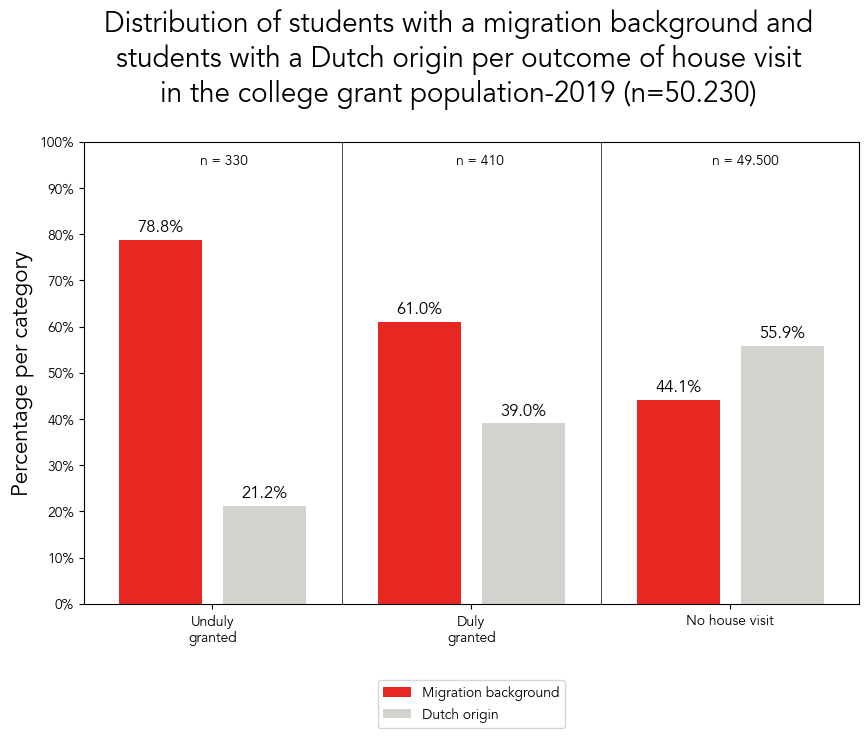

In [29]:
# data
rows = house_visit
columns = col_mig_binary

# colors
colors = c_mig_binary
custom_xticks = ['Unduly\ngranted', 'Duly\ngranted', 'No house visit']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per category'

# figure title
figure_title = f'Distribution of students with a migration background and\nstudents with a Dutch origin per outcome of house visit\nin the college grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                custom_xticks=custom_xticks,
                                set_xticks=True, 
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title=1.1)

# plot coordinates
step_per_n = 0.33
start_x_n= 0.15
start_y_n = 0.95

# n for different outcomes
n_unduly = df.loc['Outcome house visit: unduly', 'Total']
n_duly = df.loc['Outcome house visit: duly', 'Total']

# annotation of sample size plot1
x_i = start_x_n
for n in [n_unduly, n_duly, n_no_house_visit]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

### 3 groups: (non-)European migration background and Dutch origin

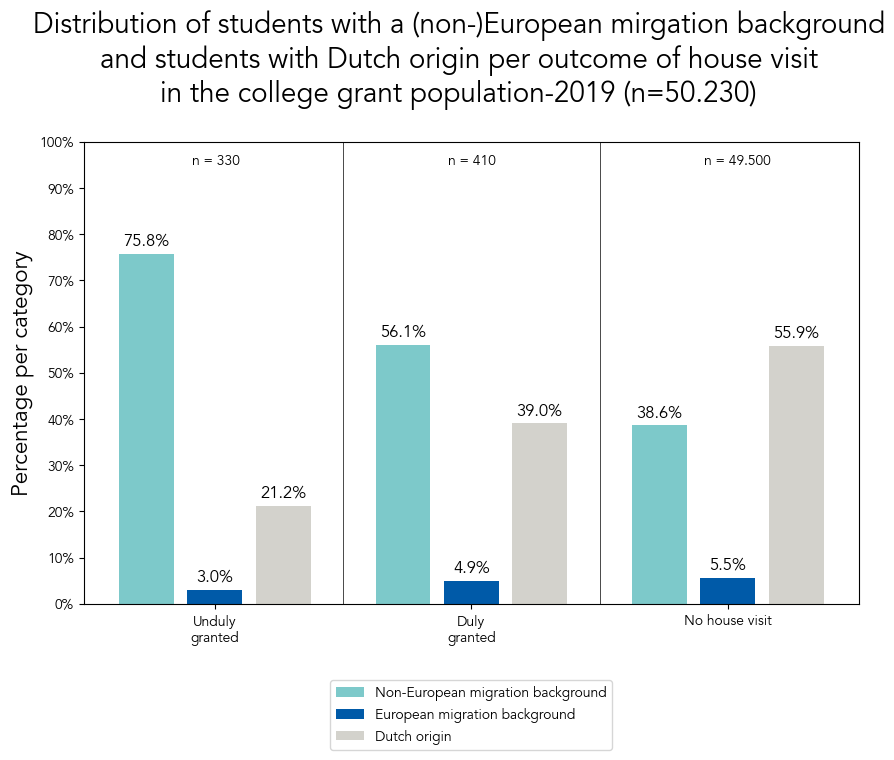

In [30]:
# data
rows = house_visit
columns = col_mig_eu

# colors
colors = c_mig_eu
custom_xticks = ['Unduly\ngranted', 'Duly\ngranted', 'No house visit']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per category'

# figure title
figure_title = f'Distribution of students with a (non-)European mirgation background\nand students with Dutch origin per outcome of house visit\nin the college grant population-{year} (n={n_total_pop})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                custom_xticks=custom_xticks,
                                set_xticks=True, 
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title=1.1)

# plot coordinates
step_per_n = 0.33
start_x_n= 0.14
start_y_n = 0.95

# annotation of sample size plot1
x_i = start_x_n
for n in [n_unduly, n_duly, n_no_house_visit]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

## Sub-question: Which groups were rightly and wrongly be selected for a control procedure?

### 2 groups: migration background and Dutch origin

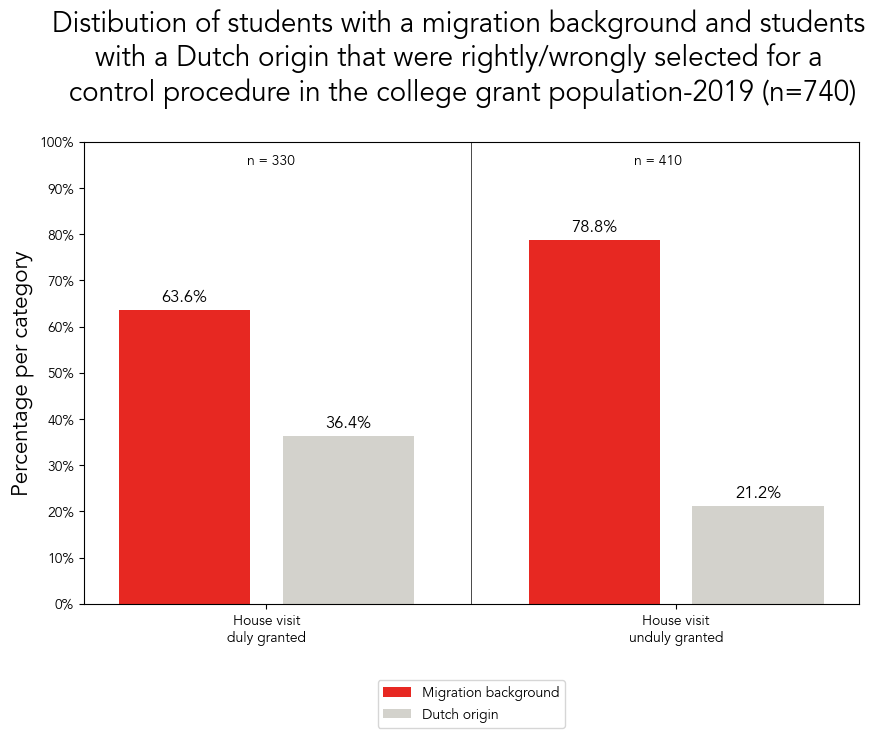

In [31]:
# data
rows = house_visit_right_wrong
columns = col_mig_binary

# colors
colors = c_mig_binary
custom_xticks = ['House visit\nduly granted', 'House visit\nunduly granted']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per category'

# figure title
figure_title = f'Distibution of students with a migration background and students\nwith a Dutch origin that were rightly/wrongly selected for a\n control procedure in the college grant population-{year} (n={n_house_visits})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title=1.1)

# plot coordinates
step_per_n = 0.5
start_x_n= 0.21
start_y_n = 0.95

# annotation of sample size plot1
x_i = start_x_n
for n in [n_unduly, n_duly]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

## 3 groups: (non-)European migration background and Dutch origin

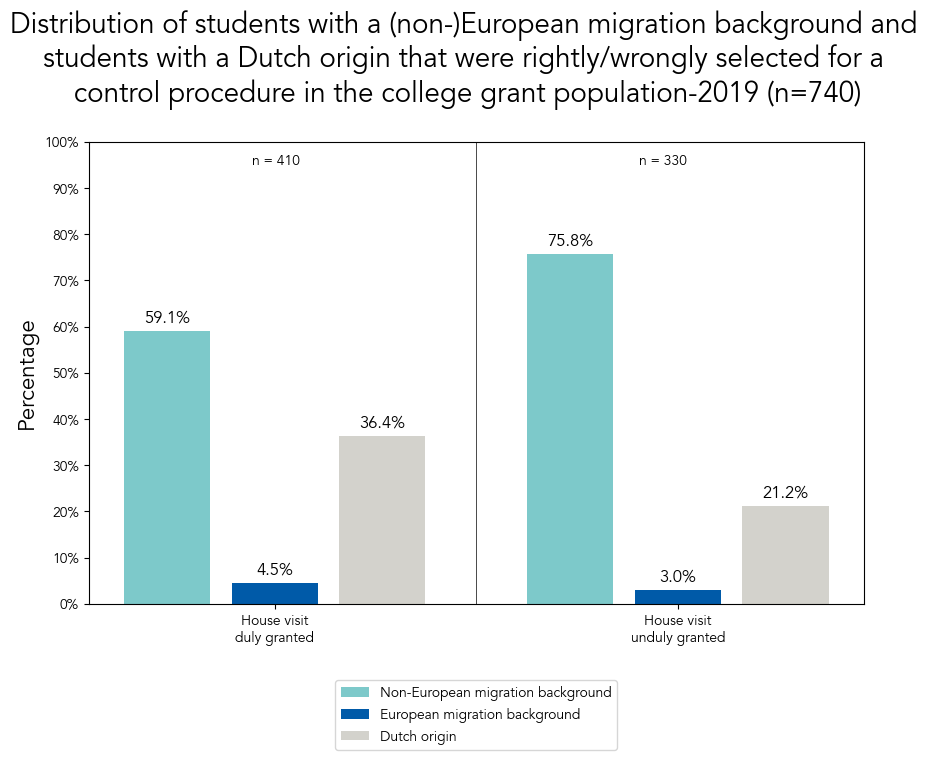

In [32]:
# data
rows = house_visit_right_wrong
columns = col_mig_eu

# colors
colors = c_mig_eu
custom_xticks = ['House visit\nduly granted', 'House visit\nunduly granted']

# y-ticks
ylim = 1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage'

# figure title
figure_title = f'Distribution of students with a (non-)European migration background and\nstudents with a Dutch origin that were rightly/wrongly selected for a\n control procedure in the college grant population-{year} (n={n_house_visits})'

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                set_xticks=True, 
                                custom_xticks=custom_xticks,
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title=1.1)

# plot coordinates
step_per_n = 0.5
start_x_n= 0.21
start_y_n = 0.95

# annotation of sample size plot1
x_i = start_x_n
for n in [n_duly, n_unduly]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

# Summary

## Funnel visualization

### 2 groups: migration background and Dutch origin

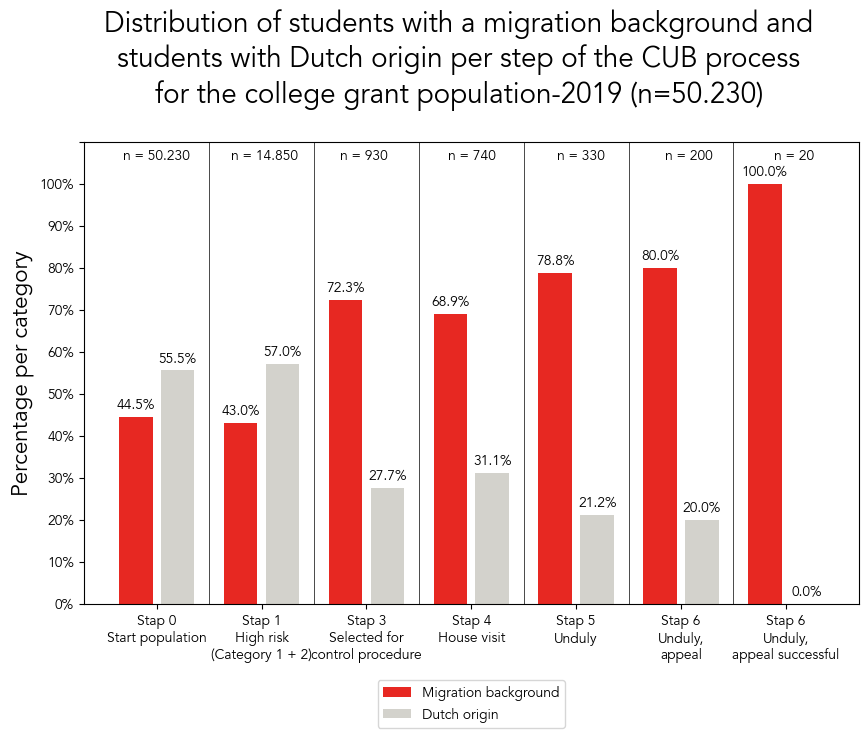

In [33]:
# data
rows = ['Total',
        'High risk',
        'Selected for control: yes',
        'House visit', 
        'Outcome house visit: unduly',
        'Unduly, appeal',
        'Unduly, appeal successful']
columns = col_mig_binary

# colors
colors = c_mig_binary

# y-ticks
ylim = 1.1
n_yticks = 11

# y-axis label
yaxis_label = 'Percentage per category'

# figure title
figure_title = f'Distribution of students with a migration background and\nstudents with Dutch origin per step of the CUB process\nfor the college grant population-{year} (n={n_total_pop})'

# custom xticks
custom_xticks = ['Stap 0\nStart population',
                 'Stap 1\nHigh risk\n(Category 1 + 2)',
                 'Stap 3\nSelected for\ncontrol procedure',
                 'Stap 4\nHouse visit',
                 'Stap 5\nUnduly',
                 'Stap 6\nUnduly,\nappeal',
                 'Stap 6\nUnduly,\nappeal successful']

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                custom_xticks=custom_xticks,
                                set_xticks=True, 
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title = 1.1,
                                fontsize_text_bars=10)

# get the n of 'Total'
n_Total = df.loc['Total', 'Total']

# get the n of 'high risk'
n_H = df.loc['High risk', 'Total']
perc_H_of_total = n_H / n_Total

# get the n of 'selected for control procedure'
n_G = df.loc['Selected for control: yes', 'Total']
perc_G_of_H = n_G / n_H

# get the n of 'house visit'
n_HB = df.loc['House visit', 'Total']
perc_HB_of_G = n_HB / n_G

# get the n of 'unduly'
n_O = df.loc['Outcome house visit: unduly', 'Total']
perc_O_of_HB = n_O / n_HB

# get the n of 'unduly, appeal'
n_OB = df.loc['Unduly, appeal', 'Total']
perc_OB_of_O = n_OB / n_O

# get the n of the 'unduly, appeal successful'
n_OBG = df.loc['Unduly, appeal successful', 'Total']
perc_OBG_of_OB = n_OBG / n_O

# 7 categories
step_per_n = 0.14
start_x_n= 0.05
start_y_n = 0.96

# sample size annotation
x_i = start_x_n
for n in [n_Total, 
          n_H, 
          n_G, 
          n_HB, 
          n_O, 
          n_OB,
          n_OBG]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

### 3 groups: (non-)European migration background and Dutch origin

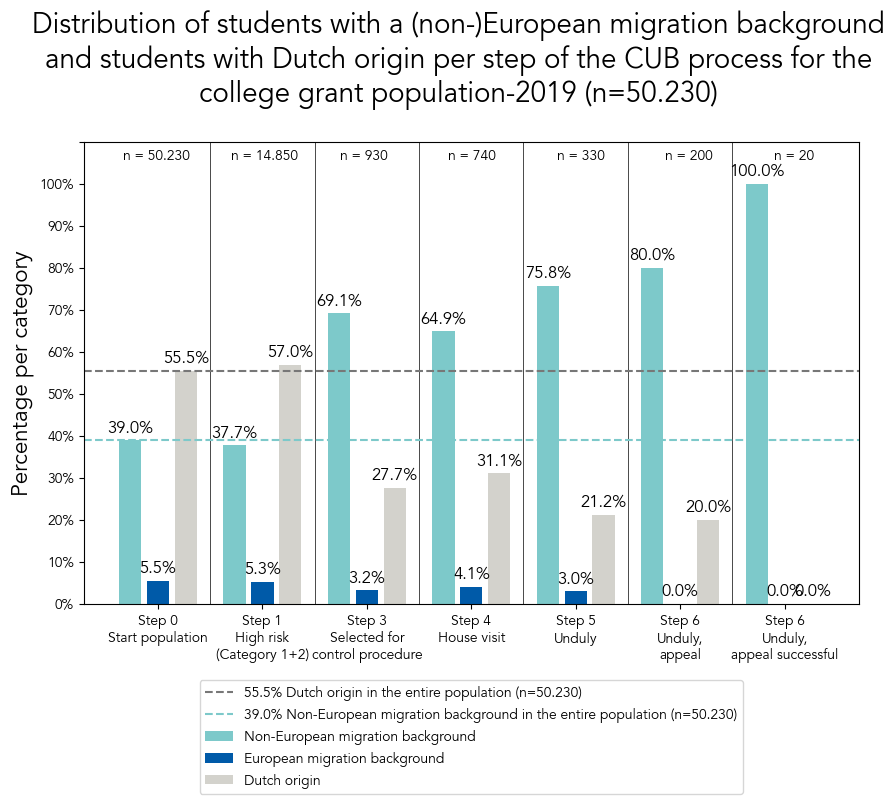

In [34]:
# data
rows = ['Total',
        'High risk',
        'Selected for control: yes',
        'House visit', 
        'Outcome house visit: unduly',
        'Unduly, appeal',
        'Unduly, appeal successful']
columns = col_mig_eu

# colors
colors = c_mig_eu

# y-axis label
yaxis_label = 'Percentage per category'

# figure title
figure_title = f'Distribution of students with a (non-)European migration background\nand students with Dutch origin per step of the CUB process for the\ncollege grant population-{year} (n={n_total_pop})'

# custom xticks
custom_xticks = ['Step 0\nStart population',
                 'Step 1\nHigh risk\n(Category 1+2)',
                 'Step 3\nSelected for\ncontrol procedure',
                 'Step 4\nHouse visit',
                 'Step 5\nUnduly',
                 'Step 6\nUnduly,\nappeal',
                 'Step 6\nUnduly,\nappeal successful']

# fill patterns - first one remains same, second one is hatched
fill_patterns = [None]

# plot function
data, fig, ax  = create_barplot(df, 
                                rows, 
                                columns, 
                                colors, 
                                custom_xticks=custom_xticks,
                                set_xticks=True, 
                                rotation_xtick_label=0,
                                position_xtick_label='center',
                                set_ylabel=yaxis_label,
                                set_ylabel_percentage=True, 
                                as_percentage_total=False, 
                                as_percentage_category=True, 
                                ylim =ylim,
                                n_yticks=n_yticks, 
                                put_number_on_top_bar=True, 
                                space_between_cat=0.25, 
                                vline_between_cat=True, 
                                figure_title=figure_title,
                                y_title = 1.1)

# get the n of 'Total'
n_Total = df.loc['Total', 'Total']

# get the n of 'high risk'
n_H = df.loc['High risk', 'Total']
perc_H_of_total = n_H / n_Total

# get the n of 'selected for control procedure'
n_G = df.loc['Selected for control: yes', 'Total']
perc_G_of_H = n_G / n_H

# get the n of 'house visit'
n_HB = df.loc['House visit', 'Total']
perc_HB_of_G = n_HB / n_G

# get the n of 'unduly'
n_O = df.loc['Outcome house visit: unduly', 'Total']
perc_O_of_HB = n_O / n_HB

# get the n of 'unduly, appeal'
n_OB = df.loc['Unduly, appeal', 'Total']
perc_OB_of_O = n_OB / n_O

# get the n of the 'unduly, appeal successful'
n_OBG = df.loc['Unduly, appeal successful', 'Total']
perc_OBG_of_OB = n_OBG / n_O

# plot variables (7 categories)
step_per_n = 0.14
start_x_n= 0.05
start_y_n = 0.96

# sample size annotation
x_i = start_x_n
for n in [n_Total, 
          n_H, 
          n_G, 
          n_HB, 
          n_O, 
          n_OB,
          n_OBG]:
        ax.text(x_i, start_y_n, 'n = {:,}'.format(int(n)).replace(',','.'), fontsize=10, transform=ax.transAxes)
        x_i += step_per_n

# horizontal lines
ax.axhline(y=avg_NL, color='#777777', label=f'{(avg_NL*100):.1f}% Dutch origin in the entire population (n={n_total_pop})', linestyle='--')
ax.axhline(y=avg_migr_non_eu, color=c_migr_non_eu_and_child_migr_non_eu, label=f'{(avg_migr_non_eu*100):.1f}% Non-European migration background in the entire population (n={n_total_pop})', linestyle='--')

# legend
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

plt.show()

## Probabilities

In [35]:
# take the n of students with a non-European migration background and Dutch origin
n_migr_non_eu = df.loc['Total', 'Non-European migration background']
n_NL = df.loc['Total', 'Dutch origin']

print('-----Probabilities: classified as high risk by risk profile-----')
# n hoog risico voor Non-European migrants en kinderen van Non-European migrants
n_H_migr_non_eu = df.loc['High risk', 'Non-European migration background']
n_H_NL = df.loc['High risk', 'Dutch origin']
n_L_migr_non_eu = df.loc['Low risk', 'Non-European migration background']
n_L_NL = df.loc['Low risk', 'Dutch origin']
n_O_migr_non_eu = df.loc['Unknown risk', 'Non-European migration background']
n_O_NL = df.loc['Unknown risk', 'Dutch origin']

# percentage high risk for students with non-European migration background
perc_H_migr_non_eu = n_H_migr_non_eu / n_migr_non_eu
perc_H_NL = n_H_NL / n_NL
ratio = perc_H_migr_non_eu / perc_H_NL
print('Percentage high risk for students with non-European migration background:', perc_H_migr_non_eu)
print('Percentage high risk for students with Dutch origin:', perc_H_NL)
print('Students with a non-European migration background have {:.1f} higher probability to be assigned high risk by the risk profile than students with a Dutch origin\n'.format(ratio))

print('-----Probabilities: selected for control procedure-----')
# n selected for control procedure for students with a non-European migration background
n_sel_migr_non_eu = df.loc['Selected for control: yes', 'Non-European migration background']
n_sel_NL = df.loc['Selected for control: yes', 'Dutch origin']

# percentage of students with a non-European migration background and Dutch origin selected for control procedure
perc_sel_migr_non_eu = n_sel_migr_non_eu / n_migr_non_eu
perc_sel_NL = n_sel_NL / n_NL

ratio = perc_sel_migr_non_eu / perc_sel_NL
print('Percentage selected for control procedure with non-European migration background:', perc_sel_migr_non_eu)
print('Percentage selected for control procedure with Dutch origin:', perc_sel_NL)
print('Students with a non-European migration background have {:.1f} higher probability to be manually selected for a control procedure than students with a Dutch origin\n'.format(ratio))

print('-----Probabilities: selected for control procedure high/low/unknown risk-----')
# n high/low/unknown risk and selected for control procedure with a non-EU migration background and NL origin
n_H_sel_migr_non_eu = df.loc['High risk and selected for control', 'Non-European migration background']
n_H_sel_nl = df.loc['High risk and selected for control', 'Dutch origin']
n_L_sel_migr_non_eu = df.loc['Low risk and selected for control', 'Non-European migration background']
n_L_sel_nl = df.loc['Low risk and selected for control', 'Dutch origin']
n_O_sel_migr_non_eu = df.loc['Unknown risk and selected for control', 'Non-European migration background']
n_O_sel_nl = df.loc['Unknown risk and selected for control', 'Dutch origin']

# House visits within population high risk
perc_H_sel_migr_non_eu = n_H_sel_migr_non_eu / n_H_migr_non_eu
perc_H_sel_NL = n_H_sel_nl / n_H_NL
ratio = perc_H_sel_migr_non_eu / perc_H_sel_NL
print('Percentage of house visits at a student with a non-European migration background that is classified as high risk:', perc_H_sel_migr_non_eu)
print('Percentage of house visits at a student with Dutch origin that is classified as high risk:', perc_H_sel_NL)
print('Students classified as high risk with a non-European migration background have {:.1f} higher probability to be selected for a house visit than the same students with a Dutch origin\n'.format(ratio))

# House visits within population low risk
perc_L_sel_migr_non_eu = n_L_sel_migr_non_eu / n_L_migr_non_eu
perc_L_sel_NL = n_L_sel_nl / n_L_NL
ratio = perc_L_sel_migr_non_eu / perc_L_sel_NL
print('Percentage of house visits at a student with a non-European migration background that is classified as low risk:', perc_L_sel_migr_non_eu)
print('Percentage of house visits at a student with Dutch origin that is classified as low risk:', perc_L_sel_NL)
print('Students classified as low risk with a non-European migration background have {:.1f} higher probability to be selected for a house visit than the same students with a Dutch origin\n'.format(ratio))

# House visits within population unknown risk
perc_O_sel_migr_non_eu = n_O_sel_migr_non_eu / n_O_migr_non_eu
perc_O_sel_NL = n_O_sel_nl / n_O_NL
ratio = perc_O_sel_migr_non_eu / perc_O_sel_NL
print('Percentage of house visits at a student with a non-European migration background classified as unknown risk:', perc_O_sel_migr_non_eu)
print('Percentage of house visits at a student with Dutch origin classified as unknown risk:', perc_O_sel_NL)
print('Students classified as unknown risk with a non-European migration background have {:.1f} higher probability to be selected for a house visit than the same students with a Dutch origin\n'.format(ratio))

print('-----Probabilities: wrong house visits-----')
# n incorrect house visits for students with a non-European migration background and NL
n_incorrect_migr_non_eu = df.loc['House visit, duly (directly and after appeal)', 'Non-European migration background']
n_incorrect_NL = df.loc['House visit, duly (directly and after appeal)', 'Dutch origin']
n_house_visits_migr_non_eu = df.loc['House visit', 'Non-European migration background']
n_house_visits_NL = df.loc['House visit', 'Dutch origin']

# percentage wrong house visits for students with non-European migration background and NL
perc_incorrect_migr_non_eu = n_incorrect_migr_non_eu / n_migr_non_eu
perc_incorrect_NL = n_incorrect_NL / n_NL
ratio = perc_incorrect_migr_non_eu / perc_incorrect_NL

print('Percentage incorrect house visits for students with a non-European migration background:', perc_incorrect_migr_non_eu)
print('Percentage incorrect house visits for students with a Dutch origin:', perc_incorrect_NL)
print('Students with a non-European migration background have {:.1f} higher probability for having an incorrect house visit than students with a Dutch origin'.format(ratio))

-----Probabilities: classified as high risk by risk profile-----
Percentage high risk for students with non-European migration background: 0.28600612870275793
Percentage high risk for students with Dutch origin: 0.30333452850484044
Students with a non-European migration background have 0.9 higher probability to be assigned high risk by the risk profile than students with a Dutch origin

-----Probabilities: selected for control procedure-----
Percentage selected for control procedure with non-European migration background: 0.03319713993871297
Percentage selected for control procedure with Dutch origin: 0.00932233775546791
Students with a non-European migration background have 3.6 higher probability to be manually selected for a control procedure than students with a Dutch origin

-----Probabilities: selected for control procedure high/low/unknown risk-----
Percentage of house visits at a student with a non-European migration background that is classified as high risk: 0.1017857142857142